# Milky Way
This notebook is me trying to get it set up so that I can do the same lmc/smc binary fraction that I've done, but for the Milky Way stars. This might be a bit of a problem because the data files are that much larger.

In [1]:
from astropy.io import fits
from astropy.table import Table, vstack, Column
import numpy as np
import matplotlib.pyplot as plt

In [2]:
star_mw_data = fits.getdata('/home/cody/Binary Search/DR 14 data/allStar-l31c.2.fits')
visi_mw_data = fits.getdata('/home/cody/Binary Search/DR 14 data/allVisit-l31c.2.fits')

In [3]:
len(star_mw_data), len(visi_mw_data)

(277371, 1054381)

## Data Clean
If I try to run my BinaryDataClean3 program the Kernel keeps crashing. I'm assuming this is from memory problems and that the files are too large to handel all at once. So the first thing I need to do is run 'cuts' in smaller chunks and combine all the answers.
First get rid of any infinities or Nan's

In [4]:
visi_mw_data = visi_mw_data[np.isfinite(visi_mw_data['VHELIO'])]

In [5]:
len(visi_mw_data)

1042437

Now I want to get rid of low snr points

In [6]:
visi_mw_data = visi_mw_data[visi_mw_data['SNR'] >= 5]

In [7]:
len(visi_mw_data)

1028338

I still have some un-physical points that are faster than light, so I need to get rid of these. 

In [8]:
visi_mw_data = visi_mw_data[visi_mw_data['VHELIO'] < 10**4]

In [12]:
len(visi_mw_data)

(1016668, numpy.ndarray)

In [ ]:
import pickle as rick
import os
outfile = "milky-way-allVisit-reduced.pck"
if os.path.exists(outfile): os.remove(outfile)
rick.dump(visi_mw_data, open(outfile, "wb"))

#### nvisits_cut
I only want to consider stars that have at least 5 observations so I'm going to get rid of stars with fewer than 5 observations

In [13]:
star_mw_data = star_mw_data[star_mw_data['NVISITS'] >= 5]

In [14]:
len(star_mw_data)

47525

In [18]:
type(star_mw_data['LOGG'])

numpy.ndarray

That's a lot fewer stars to deal with

#### red giants
I want to limit my sample to stars that are Red Giants to make sure that we match with the Magellanic Clouds. FIrst get rid of bad Teff, LOGG, and FE_H values, then limit them to make sure they fall into red giant catigories.

In [19]:
star_mw_data = star_mw_data[star_mw_data['TEFF'] > 0]
print(len(star_mw_data))
star_mw_data = star_mw_data[star_mw_data['LOGG'] > 0]
print(len(star_mw_data))
star_mw_data = star_mw_data[star_mw_data['FE_H'] > -100]
print(len(star_mw_data))

39002
23346
23293


In [20]:
star_mw_data = star_mw_data[star_mw_data['TEFF'] <= 5500]
star_mw_data = star_mw_data[star_mw_data['LOGG'] <= 3.7 + 0.1*star_mw_data['FE_H']]

In [21]:
print(len(star_mw_data))

23146


#### Iso Fits
Now comes the hard part. I need to be able to fit isochrone values to the star. I think at this point I can probably run the pre-built binarydataclean3 program I have, so we'll try that first

In [22]:
%run "/home/cody/Binary Search/BinaryDataClean3.py"

In [23]:
Tables = BinaryDataClean3('/home/cody/Binary Search/DR 14 data/allStar-l31c.2.fits',
                          '/home/cody/Binary Search/DR 14 data/allVisit-l31c.2.fits',
                          '/home/cody/Binary Search/parsec_decamsdss_all.fits.gz')
iso = fits.getdata('/home/cody/Binary Search/parsec_decamsdss_all.fits.gz')

In [39]:
foo = Table(star_mw_data[0:1])
foo = Tables.iso_fit(foo, iso)
foo

Done with 0.000000


APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE_TARGET3,TARGFLAGS,SURVEY,NINST [3],NVISITS,COMBTYPE,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,OBSVHELIO_AVG,OBSVSCATTER,OBSVERR,OBSVERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,MEANFIB,SIGFIB,SNREV,APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,MIN_H,MAX_H,MIN_JK,MAX_JK,PARAM [9],FPARAM [9],"PARAM_COV [9,9]","FPARAM_COV [9,9]",TEFF,TEFF_ERR,LOGG,LOGG_ERR,VMICRO,VMACRO,VSINI,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [9],FELEM [26],FELEM_ERR [26],X_H [26],X_H_ERR [26],X_M [26],X_M_ERR [26],C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,P_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,FE_H,CO_FE,NI_FE,CU_FE,GE_FE,RB_FE,Y_FE,ND_FE,C_FE_ERR,CI_FE_ERR,N_FE_ERR,O_FE_ERR,NA_FE_ERR,MG_FE_ERR,AL_FE_ERR,SI_FE_ERR,P_FE_ERR,S_FE_ERR,K_FE_ERR,CA_FE_ERR,TI_FE_ERR,TIII_FE_ERR,V_FE_ERR,CR_FE_ERR,MN_FE_ERR,FE_H_ERR,CO_FE_ERR,NI_FE_ERR,CU_FE_ERR,GE_FE_ERR,RB_FE_ERR,Y_FE_ERR,ND_FE_ERR,C_FE_FLAG,CI_FE_FLAG,N_FE_FLAG,O_FE_FLAG,NA_FE_FLAG,MG_FE_FLAG,AL_FE_FLAG,SI_FE_FLAG,P_FE_FLAG,S_FE_FLAG,K_FE_FLAG,CA_FE_FLAG,TI_FE_FLAG,TIII_FE_FLAG,V_FE_FLAG,CR_FE_FLAG,MN_FE_FLAG,FE_H_FLAG,CO_FE_FLAG,NI_FE_FLAG,CU_FE_FLAG,GE_FE_FLAG,RB_FE_FLAG,Y_FE_FLAG,ND_FE_FLAG,ELEM_CHI2 [26],ELEMFLAG [26],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50],"FPARAM_CLASS [23,9]",CHI2_CLASS [23],ISO_MEANM,ISO_MEDIANM,ISO_STDM,ISO_MEANL,ISO_MEDIANL,ISO_STDL,ISO_MEANR
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,solMass,solMass,solMass,solLum,solLum,solLum,solRad
str45,str34,str46,str38,str18,str8,int16,str16,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,int32,str140,str14,int32,int32,int32,int16,float32,int32,str165,int32,str74,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,str5,str4,str6,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str5,int32,str183,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,str23,str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str17,float32,float32,int16,int16,float32,float32,str20,str845,str804,int32,int32,float32,float32,float64,float64,float64,float64,float64,float64,float64
apogee.apo25m.s.stars.5045.2M00000943+6254542,50

keeps crashing when I try to run it all at once, so I'm going to cut it up into 4 smaller bits and then run those separately and then combine it all together

In [40]:
foo = Table(star_mw_data[0:1])
foo = Tables.iso_fit(foo, iso)
a = 10
for n in range(a):
    start = len(star_mw_data)//a * n
    end = len(star_mw_data)//a * (n+1)
    if n == a-1:
        mw_foo = star_mw_data[start:]
    else:
        mw_foo = star_mw_data[start:end]
    star_mw_data_foo = Tables.iso_fit(mw_foo, iso)
    foo = vstack([star_mw_data_foo, foo])
    print(type(foo['LOGG']))

Done with 0.000000
Done with 0.000000
No good fits in 3 sigma of erros. Star 2M00002388+6151472, row 7
No good fits in 3 sigma of erros. Star 2M00012599+7010526, row 32
No good fits in 3 sigma of erros. Star 2M00014650+7009328, row 38
No good fits in 3 sigma of erros. Star 2M00015905+0052119, row 40
No good fits in 3 sigma of erros. Star 2M00045146+7010262, row 70
No good fits in 3 sigma of erros. Star 2M00053477+7129567, row 75
No good fits in 3 sigma of erros. Star 2M00073858+0010448, row 91
No good fits in 3 sigma of erros. Star 2M00080678+0057034, row 100
No good fits in 3 sigma of erros. Star 2M00083572+0043587, row 107
No good fits in 3 sigma of erros. Star 2M00083769+7149289, row 108
No good fits in 3 sigma of erros. Star 2M00092789+0145417, row 116
No good fits in 3 sigma of erros. Star 2M00131968+6619142, row 156
No good fits in 3 sigma of erros. Star 2M00132433+6716566, row 163
Done with 200.000000
No good fits in 3 sigma of erros. Star 2M00161756+7008036, row 228
No good fit

No good fits in 3 sigma of erros. Star 2M03362809+7013274, row 2029
No good fits in 3 sigma of erros. Star 2M03364261+4636435, row 2033
No good fits in 3 sigma of erros. Star 2M03384253+7049156, row 2072
No good fits in 3 sigma of erros. Star 2M03390604+7901431, row 2081
Done with 2100.000000
No good fits in 3 sigma of erros. Star 2M03404484+3249052, row 2119
No good fits in 3 sigma of erros. Star 2M03411320+4539160, row 2128
Done with 2200.000000
No good fits in 3 sigma of erros. Star 2M03481809+7931234, row 2232
No good fits in 3 sigma of erros. Star 2M03483385+5018319, row 2235
No good fits in 3 sigma of erros. Star 2M03494244+4854281, row 2242
No good fits in 3 sigma of erros. Star 2M03495391+7932383, row 2250
No good fits in 3 sigma of erros. Star 2M03514311+4935516, row 2277
Done with 2300.000000
<class 'astropy.table.column.Column'>
Done with 0.000000
No good fits in 3 sigma of erros. Star 2M03551219+5008354, row 9
No good fits in 3 sigma of erros. Star 2M04000634+5307547, row 7

No good fits in 3 sigma of erros. Star 2M05491599+5322220, row 149
No good fits in 3 sigma of erros. Star 2M05491829+5155533, row 152
No good fits in 3 sigma of erros. Star 2M05503155+5223030, row 195
Done with 200.000000
No good fits in 3 sigma of erros. Star 2M05525355+5140141, row 256
Done with 300.000000
No good fits in 3 sigma of erros. Star 2M05565418+3202121, row 314
No good fits in 3 sigma of erros. Star 2M05580538+3127569, row 347
No good fits in 3 sigma of erros. Star 2M05590764+1345307, row 382
Done with 400.000000
No good fits in 3 sigma of erros. Star 2M06000559+1324329, row 421
No good fits in 3 sigma of erros. Star 2M06012273+3046403, row 472
Done with 500.000000
No good fits in 3 sigma of erros. Star 2M06024165+3127449, row 519
No good fits in 3 sigma of erros. Star 2M06033343+1340011, row 546
No good fits in 3 sigma of erros. Star 2M06043629+3007156, row 582
Done with 600.000000
No good fits in 3 sigma of erros. Star 2M06054645+1313217, row 630
No good fits in 3 sigma 

No good fits in 3 sigma of erros. Star 2M07280501+4017386, row 993
No good fits in 3 sigma of erros. Star 2M07281433+2438101, row 998
Done with 1000.000000
No good fits in 3 sigma of erros. Star 2M07282739+2333413, row 1008
No good fits in 3 sigma of erros. Star 2M07283563+4017495, row 1013
No good fits in 3 sigma of erros. Star 2M07284393+2424382, row 1019
No good fits in 3 sigma of erros. Star 2M07292663+2406173, row 1031
No good fits in 3 sigma of erros. Star 2M07293093+3922105, row 1034
No good fits in 3 sigma of erros. Star 2M07295977+3936485, row 1047
No good fits in 3 sigma of erros. Star 2M07303652+3951504, row 1065
No good fits in 3 sigma of erros. Star 2M07304469+3940491, row 1067
No good fits in 3 sigma of erros. Star 2M07311124+4011594, row 1081
No good fits in 3 sigma of erros. Star 2M07313974+3718155, row 1097
Done with 1100.000000
No good fits in 3 sigma of erros. Star 2M07314739+3712020, row 1102
No good fits in 3 sigma of erros. Star 2M07321089+2357272, row 1115
No goo

No good fits in 3 sigma of erros. Star 2M10511813-0408315, row 356
No good fits in 3 sigma of erros. Star 2M10511886-0242304, row 357
No good fits in 3 sigma of erros. Star 2M10512722-0307071, row 360
No good fits in 3 sigma of erros. Star 2M10522611-0251460, row 368
No good fits in 3 sigma of erros. Star 2M10524610-0336012, row 369
No good fits in 3 sigma of erros. Star 2M10530836-0223447, row 376
No good fits in 3 sigma of erros. Star 2M10542529-0415341, row 390
Done with 400.000000
No good fits in 3 sigma of erros. Star 2M10560106-0320453, row 407
No good fits in 3 sigma of erros. Star 2M10571145-0324455, row 421
No good fits in 3 sigma of erros. Star 2M10591715+4946172, row 433
No good fits in 3 sigma of erros. Star 2M10595749+4446439, row 434
No good fits in 3 sigma of erros. Star 2M11004903+4454222, row 439
No good fits in 3 sigma of erros. Star 2M11020465-0607013, row 466
No good fits in 3 sigma of erros. Star 2M11021743+4908079, row 472
Done with 500.000000
No good fits in 3 si

No good fits in 3 sigma of erros. Star 2M14565773+2213157, row 2006
No good fits in 3 sigma of erros. Star 2M14583323+2305353, row 2031
No good fits in 3 sigma of erros. Star 2M14592242+2127127, row 2046
No good fits in 3 sigma of erros. Star 2M15000558+2135142, row 2061
No good fits in 3 sigma of erros. Star 2M15000794+2029103, row 2064
No good fits in 3 sigma of erros. Star 2M15010221+2703159, row 2086
No good fits in 3 sigma of erros. Star 2M15011178+2615068, row 2090
No good fits in 3 sigma of erros. Star 2M15011635+2628491, row 2092
Done with 2100.000000
No good fits in 3 sigma of erros. Star 2M15031516+2134207, row 2146
No good fits in 3 sigma of erros. Star 2M15031789+2310156, row 2148
No good fits in 3 sigma of erros. Star 2M15034295+2224510, row 2171
No good fits in 3 sigma of erros. Star 2M15034340+2641309, row 2172
No good fits in 3 sigma of erros. Star 2M15040102+2036446, row 2181
Done with 2200.000000
No good fits in 3 sigma of erros. Star 2M15044407+2559318, row 2204
No g

No good fits in 3 sigma of erros. Star 2M16341218-0010514, row 1620
No good fits in 3 sigma of erros. Star 2M16342315-0145464, row 1628
No good fits in 3 sigma of erros. Star 2M16344039+0046134, row 1640
No good fits in 3 sigma of erros. Star 2M16345378-0030099, row 1645
No good fits in 3 sigma of erros. Star 2M16351864-0119479, row 1669
No good fits in 3 sigma of erros. Star 2M16354890+0006572, row 1691
Done with 1700.000000
No good fits in 3 sigma of erros. Star 2M16361732+4311182, row 1703
No good fits in 3 sigma of erros. Star 2M16362010-0026205, row 1704
No good fits in 3 sigma of erros. Star 2M16363670-0117348, row 1713
No good fits in 3 sigma of erros. Star 2M16364161+4319191, row 1714
No good fits in 3 sigma of erros. Star 2M16375013-0000362, row 1752
No good fits in 3 sigma of erros. Star 2M16375154+4258429, row 1753
No good fits in 3 sigma of erros. Star 2M16380443-0117529, row 1764
No good fits in 3 sigma of erros. Star 2M16384565+4335016, row 1778
Done with 1800.000000
No g

No good fits in 3 sigma of erros. Star 2M17165519+4301588, row 352
No good fits in 3 sigma of erros. Star 2M17165620+4306121, row 353
No good fits in 3 sigma of erros. Star 2M17165772+4314115, row 355
No good fits in 3 sigma of erros. Star 2M17165903+5838220, row 357
No good fits in 3 sigma of erros. Star 2M17165967+4301058, row 359
No good fits in 3 sigma of erros. Star 2M17170033+4311478, row 360
No good fits in 3 sigma of erros. Star 2M17170043+4305117, row 361
No good fits in 3 sigma of erros. Star 2M17170318+4307579, row 364
No good fits in 3 sigma of erros. Star 2M17170394+4302031, row 365
No good fits in 3 sigma of erros. Star 2M17171221+4302209, row 373
No good fits in 3 sigma of erros. Star 2M17171307+4309483, row 374
No good fits in 3 sigma of erros. Star 2M17171308+4308244, row 375
No good fits in 3 sigma of erros. Star 2M17172166+4311031, row 382
No good fits in 3 sigma of erros. Star 2M17172292-2506543, row 383
No good fits in 3 sigma of erros. Star 2M17172331+4256556, row

No good fits in 3 sigma of erros. Star 2M18021779-3012241, row 976
No good fits in 3 sigma of erros. Star 2M18022359-0914405, row 979
No good fits in 3 sigma of erros. Star 2M18022494-3055312, row 981
No good fits in 3 sigma of erros. Star 2M18023419-0942088, row 987
No good fits in 3 sigma of erros. Star 2M18023910-0823574, row 991
No good fits in 3 sigma of erros. Star 2M18023955-0930389, row 993
No good fits in 3 sigma of erros. Star 2M18024265-3125380, row 994
No good fits in 3 sigma of erros. Star 2M18024372-2921285, row 995
No good fits in 3 sigma of erros. Star 2M18024917-3129381, row 999
Done with 1000.000000
No good fits in 3 sigma of erros. Star 2M18025557-3125183, row 1002
No good fits in 3 sigma of erros. Star 2M18030102-3021251, row 1006
No good fits in 3 sigma of erros. Star 2M18030254-2917499, row 1009
No good fits in 3 sigma of erros. Star 2M18030987-3011459, row 1013
No good fits in 3 sigma of erros. Star 2M18031215-3131061, row 1016
No good fits in 3 sigma of erros. S

No good fits in 3 sigma of erros. Star 2M18082790-3120273, row 1352
No good fits in 3 sigma of erros. Star 2M18082942-0830275, row 1353
No good fits in 3 sigma of erros. Star 2M18084676-0846254, row 1362
No good fits in 3 sigma of erros. Star 2M18085807-0834485, row 1371
No good fits in 3 sigma of erros. Star 2M18090845-3117579, row 1375
No good fits in 3 sigma of erros. Star 2M18091139-3122220, row 1377
No good fits in 3 sigma of erros. Star 2M18093252-0843337, row 1381
No good fits in 3 sigma of erros. Star 2M18100202-0809009, row 1390
No good fits in 3 sigma of erros. Star 2M18102226-0830335, row 1393
No good fits in 3 sigma of erros. Star 2M18102435-0846594, row 1395
No good fits in 3 sigma of erros. Star 2M18102688-0925007, row 1397
No good fits in 3 sigma of erros. Star 2M18103272-0751172, row 1400
No good fits in 3 sigma of erros. Star 2M18104193-0927102, row 1401
No good fits in 3 sigma of erros. Star 2M18111245-0815345, row 1407
No good fits in 3 sigma of erros. Star 2M1811263

No good fits in 3 sigma of erros. Star 2M18283651+0014024, row 1837
No good fits in 3 sigma of erros. Star 2M18284275-0059303, row 1840
No good fits in 3 sigma of erros. Star 2M18284863-0324252, row 1845
No good fits in 3 sigma of erros. Star 2M18285122-0025444, row 1846
No good fits in 3 sigma of erros. Star 2M18285330-0209481, row 1847
No good fits in 3 sigma of erros. Star 2M18290406+0013282, row 1854
No good fits in 3 sigma of erros. Star 2M18290752-0319079, row 1858
No good fits in 3 sigma of erros. Star 2M18291595-0443322, row 1862
No good fits in 3 sigma of erros. Star 2M18292051-0235408, row 1864
No good fits in 3 sigma of erros. Star 2M18292356-0053112, row 1867
No good fits in 3 sigma of erros. Star 2M18292593-0419474, row 1868
No good fits in 3 sigma of erros. Star 2M18293060-0340086, row 1871
No good fits in 3 sigma of erros. Star 2M18293262-0039538, row 1874
No good fits in 3 sigma of erros. Star 2M18293491-0400399, row 1876
No good fits in 3 sigma of erros. Star 2M1829417

No good fits in 3 sigma of erros. Star 2M18341020-0741571, row 2112
No good fits in 3 sigma of erros. Star 2M18341026-0108335, row 2113
No good fits in 3 sigma of erros. Star 2M18341073-0203445, row 2114
No good fits in 3 sigma of erros. Star 2M18341756-0145530, row 2115
No good fits in 3 sigma of erros. Star 2M18342099-0742054, row 2116
No good fits in 3 sigma of erros. Star 2M18343128-0649127, row 2122
No good fits in 3 sigma of erros. Star 2M18343485+0013513, row 2125
No good fits in 3 sigma of erros. Star 2M18343669+1822346, row 2127
No good fits in 3 sigma of erros. Star 2M18343839-0837544, row 2128
No good fits in 3 sigma of erros. Star 2M18344056-0147573, row 2129
No good fits in 3 sigma of erros. Star 2M18344164-0844563, row 2130
No good fits in 3 sigma of erros. Star 2M18344251-0157400, row 2133
No good fits in 3 sigma of erros. Star 2M18344326-0036521, row 2135
No good fits in 3 sigma of erros. Star 2M18344451-0659364, row 2136
No good fits in 3 sigma of erros. Star 2M1834462

No good fits in 3 sigma of erros. Star 2M18421163-0209330, row 83
No good fits in 3 sigma of erros. Star 2M18421291-0258346, row 84
No good fits in 3 sigma of erros. Star 2M18421291-0211571, row 85
No good fits in 3 sigma of erros. Star 2M18421394-0318198, row 87
No good fits in 3 sigma of erros. Star 2M18421700-0212082, row 89
No good fits in 3 sigma of erros. Star 2M18421758-0257273, row 90
No good fits in 3 sigma of erros. Star 2M18421822-0158552, row 92
No good fits in 3 sigma of erros. Star 2M18421885-0254086, row 93
No good fits in 3 sigma of erros. Star 2M18421887-0321055, row 94
No good fits in 3 sigma of erros. Star 2M18422457-0313557, row 96
No good fits in 3 sigma of erros. Star 2M18423028-0128367, row 100
No good fits in 3 sigma of erros. Star 2M18423176-0302557, row 103
No good fits in 3 sigma of erros. Star 2M18423429-0229305, row 105
No good fits in 3 sigma of erros. Star 2M18423620-0201137, row 107
No good fits in 3 sigma of erros. Star 2M18423750-0313084, row 108
No go

No good fits in 3 sigma of erros. Star 2M18461941-0130568, row 273
No good fits in 3 sigma of erros. Star 2M18462527-0310087, row 274
No good fits in 3 sigma of erros. Star 2M18462879-0302321, row 275
No good fits in 3 sigma of erros. Star 2M18462885-0109263, row 276
No good fits in 3 sigma of erros. Star 2M18463545-0236190, row 278
No good fits in 3 sigma of erros. Star 2M18463637-0130393, row 279
No good fits in 3 sigma of erros. Star 2M18463721-0233311, row 281
No good fits in 3 sigma of erros. Star 2M18463828-0307580, row 282
No good fits in 3 sigma of erros. Star 2M18464091-0339226, row 283
No good fits in 3 sigma of erros. Star 2M18464150-0139236, row 285
No good fits in 3 sigma of erros. Star 2M18464315-0339260, row 288
No good fits in 3 sigma of erros. Star 2M18464811-0247509, row 289
No good fits in 3 sigma of erros. Star 2M18465234-0140470, row 293
No good fits in 3 sigma of erros. Star 2M18465325-0247137, row 294
No good fits in 3 sigma of erros. Star 2M18465735-0212286, row

No good fits in 3 sigma of erros. Star 2M18500960+0047403, row 465
No good fits in 3 sigma of erros. Star 2M18501110-0251457, row 469
No good fits in 3 sigma of erros. Star 2M18501192+0117036, row 470
No good fits in 3 sigma of erros. Star 2M18501218+0101402, row 471
No good fits in 3 sigma of erros. Star 2M18501226+0136562, row 472
No good fits in 3 sigma of erros. Star 2M18501238+0030130, row 473
No good fits in 3 sigma of erros. Star 2M18501405-0159425, row 475
No good fits in 3 sigma of erros. Star 2M18501527-0735258, row 476
No good fits in 3 sigma of erros. Star 2M18501640-0239125, row 477
No good fits in 3 sigma of erros. Star 2M18501745+0154361, row 480
No good fits in 3 sigma of erros. Star 2M18501764-0014383, row 481
No good fits in 3 sigma of erros. Star 2M18501909+0021224, row 483
No good fits in 3 sigma of erros. Star 2M18502084-0711404, row 485
No good fits in 3 sigma of erros. Star 2M18502396-0142379, row 488
No good fits in 3 sigma of erros. Star 2M18502815-0641201, row

No good fits in 3 sigma of erros. Star 2M18532116+0000425, row 680
No good fits in 3 sigma of erros. Star 2M18532131-0544564, row 681
No good fits in 3 sigma of erros. Star 2M18532610-0617174, row 682
No good fits in 3 sigma of erros. Star 2M18532708-0545237, row 683
No good fits in 3 sigma of erros. Star 2M18532927+0135048, row 685
No good fits in 3 sigma of erros. Star 2M18533121-0810172, row 688
No good fits in 3 sigma of erros. Star 2M18533259-0611114, row 691
No good fits in 3 sigma of erros. Star 2M18533289+0202122, row 692
No good fits in 3 sigma of erros. Star 2M18533666-0832431, row 696
No good fits in 3 sigma of erros. Star 2M18533677-0719220, row 697
No good fits in 3 sigma of erros. Star 2M18533680+0019482, row 698
No good fits in 3 sigma of erros. Star 2M18533958-0621033, row 700
No good fits in 3 sigma of erros. Star 2M18533975+0155493, row 702
No good fits in 3 sigma of erros. Star 2M18534011+0021369, row 703
No good fits in 3 sigma of erros. Star 2M18534410-0639201, row

No good fits in 3 sigma of erros. Star 2M18574905+0040099, row 1027
No good fits in 3 sigma of erros. Star 2M18575358+4531335, row 1032
No good fits in 3 sigma of erros. Star 2M18575452-0543187, row 1033
No good fits in 3 sigma of erros. Star 2M18575582+0019517, row 1035
No good fits in 3 sigma of erros. Star 2M18575605-0422349, row 1036
No good fits in 3 sigma of erros. Star 2M18575613+0015285, row 1037
No good fits in 3 sigma of erros. Star 2M18575623-0317545, row 1038
No good fits in 3 sigma of erros. Star 2M18575660-0412281, row 1040
No good fits in 3 sigma of erros. Star 2M18575752-0653502, row 1044
No good fits in 3 sigma of erros. Star 2M18575975+4553296, row 1047
No good fits in 3 sigma of erros. Star 2M18580481-0756008, row 1053
No good fits in 3 sigma of erros. Star 2M18580833+0145465, row 1056
No good fits in 3 sigma of erros. Star 2M18581063-0404223, row 1059
No good fits in 3 sigma of erros. Star 2M18581717-0359051, row 1065
No good fits in 3 sigma of erros. Star 2M1858190

Done with 1600.000000
No good fits in 3 sigma of erros. Star 2M19104105-0513095, row 1604
No good fits in 3 sigma of erros. Star 2M19104168-0623057, row 1605
No good fits in 3 sigma of erros. Star 2M19104882-0507000, row 1609
No good fits in 3 sigma of erros. Star 2M19105070+3845294, row 1615
No good fits in 3 sigma of erros. Star 2M19105960-0650599, row 1620
No good fits in 3 sigma of erros. Star 2M19110064+3832088, row 1622
No good fits in 3 sigma of erros. Star 2M19110992+3813480, row 1629
No good fits in 3 sigma of erros. Star 2M19111347+3820199, row 1632
No good fits in 3 sigma of erros. Star 2M19113390-0641014, row 1645
No good fits in 3 sigma of erros. Star 2M19113645-0642157, row 1648
No good fits in 3 sigma of erros. Star 2M19115730+2707512, row 1664
No good fits in 3 sigma of erros. Star 2M19120201-0629586, row 1668
No good fits in 3 sigma of erros. Star 2M19120390+3911033, row 1670
No good fits in 3 sigma of erros. Star 2M19120653-0500104, row 1671
No good fits in 3 sigma of

No good fits in 3 sigma of erros. Star 2M19250908+1357101, row 2194
Done with 2200.000000
No good fits in 3 sigma of erros. Star 2M19251780+4141239, row 2204
No good fits in 3 sigma of erros. Star 2M19252491+1355410, row 2211
No good fits in 3 sigma of erros. Star 2M19253880+2601275, row 2215
No good fits in 3 sigma of erros. Star 2M19254493+0003365, row 2225
No good fits in 3 sigma of erros. Star 2M19254976+0130535, row 2229
No good fits in 3 sigma of erros. Star 2M19255030+0007542, row 2230
No good fits in 3 sigma of erros. Star 2M19255268+1447521, row 2233
No good fits in 3 sigma of erros. Star 2M19255806+1350102, row 2238
No good fits in 3 sigma of erros. Star 2M19255930-1212132, row 2240
No good fits in 3 sigma of erros. Star 2M19260323+0010057, row 2243
No good fits in 3 sigma of erros. Star 2M19260393+2518101, row 2244
No good fits in 3 sigma of erros. Star 2M19260466+2543090, row 2245
No good fits in 3 sigma of erros. Star 2M19261137+0131332, row 2247
No good fits in 3 sigma of

No good fits in 3 sigma of erros. Star 2M19385529+2339530, row 435
No good fits in 3 sigma of erros. Star 2M19390004+2427162, row 441
No good fits in 3 sigma of erros. Star 2M19390155+2447122, row 445
No good fits in 3 sigma of erros. Star 2M19390489+4526571, row 453
No good fits in 3 sigma of erros. Star 2M19390599+2352586, row 455
No good fits in 3 sigma of erros. Star 2M19391163+2342055, row 458
No good fits in 3 sigma of erros. Star 2M19391333+2315441, row 462
No good fits in 3 sigma of erros. Star 2M19391580+4641125, row 465
No good fits in 3 sigma of erros. Star 2M19392548+2301304, row 469
No good fits in 3 sigma of erros. Star 2M19392581+2411403, row 471
No good fits in 3 sigma of erros. Star 2M19393396+2306061, row 474
No good fits in 3 sigma of erros. Star 2M19393403+2404580, row 475
No good fits in 3 sigma of erros. Star 2M19393416+2346278, row 476
No good fits in 3 sigma of erros. Star 2M19393735+2335544, row 477
No good fits in 3 sigma of erros. Star 2M19393797+2324091, row

No good fits in 3 sigma of erros. Star 2M19453910+2340100, row 847
No good fits in 3 sigma of erros. Star 2M19454115+2457207, row 848
No good fits in 3 sigma of erros. Star 2M19454517+2344016, row 853
No good fits in 3 sigma of erros. Star 2M19455272+2508490, row 859
No good fits in 3 sigma of erros. Star 2M19455335+2313350, row 860
No good fits in 3 sigma of erros. Star 2M19455580+2334077, row 862
No good fits in 3 sigma of erros. Star 2M19460993+2453384, row 876
No good fits in 3 sigma of erros. Star 2M19461098+2443598, row 878
No good fits in 3 sigma of erros. Star 2M19461738+2307525, row 882
No good fits in 3 sigma of erros. Star 2M19462556+2245042, row 888
No good fits in 3 sigma of erros. Star 2M19462563+2414508, row 889
No good fits in 3 sigma of erros. Star 2M19462746+2715076, row 892
No good fits in 3 sigma of erros. Star 2M19462835+2439526, row 893
Done with 900.000000
No good fits in 3 sigma of erros. Star 2M19464256+2714271, row 903
No good fits in 3 sigma of erros. Star 2M

No good fits in 3 sigma of erros. Star 2M19550021+2638414, row 1235
No good fits in 3 sigma of erros. Star 2M19550057+2104236, row 1236
No good fits in 3 sigma of erros. Star 2M19550134+2210256, row 1237
No good fits in 3 sigma of erros. Star 2M19550425+2200037, row 1239
No good fits in 3 sigma of erros. Star 2M19551762+2622351, row 1247
No good fits in 3 sigma of erros. Star 2M19551888+2836115, row 1249
No good fits in 3 sigma of erros. Star 2M19552962+2132097, row 1255
No good fits in 3 sigma of erros. Star 2M19553207+2253236, row 1257
No good fits in 3 sigma of erros. Star 2M19554165+2257296, row 1263
No good fits in 3 sigma of erros. Star 2M19554265+2238370, row 1264
No good fits in 3 sigma of erros. Star 2M19554380+2137508, row 1266
No good fits in 3 sigma of erros. Star 2M19555570+2656519, row 1274
No good fits in 3 sigma of erros. Star 2M19560176+2633224, row 1279
No good fits in 3 sigma of erros. Star 2M19560729+2053052, row 1285
No good fits in 3 sigma of erros. Star 2M1956144

No good fits in 3 sigma of erros. Star 2M20322628+4001478, row 1927
No good fits in 3 sigma of erros. Star 2M20323381+3953085, row 1930
No good fits in 3 sigma of erros. Star 2M20323513+2009379, row 1931
No good fits in 3 sigma of erros. Star 2M20325951+3916233, row 1938
No good fits in 3 sigma of erros. Star 2M20333667+2025459, row 1953
No good fits in 3 sigma of erros. Star 2M20340730+5817278, row 1965
No good fits in 3 sigma of erros. Star 2M20341349+3828095, row 1967
No good fits in 3 sigma of erros. Star 2M20342438+5309278, row 1971
No good fits in 3 sigma of erros. Star 2M20343074+5303159, row 1974
No good fits in 3 sigma of erros. Star 2M20350486+2108270, row 1987
No good fits in 3 sigma of erros. Star 2M20351162+2055026, row 1988
No good fits in 3 sigma of erros. Star 2M20352524+3901225, row 1995
No good fits in 3 sigma of erros. Star 2M20353635+5446597, row 1999
Done with 2000.000000
No good fits in 3 sigma of erros. Star 2M20353847+4108389, row 2004
No good fits in 3 sigma of

No good fits in 3 sigma of erros. Star 2M21104419+1003113, row 674
No good fits in 3 sigma of erros. Star 2M21110468+1016066, row 684
Done with 700.000000
No good fits in 3 sigma of erros. Star 2M21121787+4828148, row 721
No good fits in 3 sigma of erros. Star 2M21122270+1027003, row 722
No good fits in 3 sigma of erros. Star 2M21122776+4716262, row 725
No good fits in 3 sigma of erros. Star 2M21123098+4925044, row 728
No good fits in 3 sigma of erros. Star 2M21131425+4842374, row 741
No good fits in 3 sigma of erros. Star 2M21131613+4830495, row 742
No good fits in 3 sigma of erros. Star 2M21131747+4843554, row 744
No good fits in 3 sigma of erros. Star 2M21132066+4922127, row 746
No good fits in 3 sigma of erros. Star 2M21132582+4845210, row 749
No good fits in 3 sigma of erros. Star 2M21134233+4812557, row 754
No good fits in 3 sigma of erros. Star 2M21135219+4654315, row 757
No good fits in 3 sigma of erros. Star 2M21141660+4719512, row 764
No good fits in 3 sigma of erros. Star 2M

No good fits in 3 sigma of erros. Star 2M21334203+5019032, row 1505
No good fits in 3 sigma of erros. Star 2M21341605-0043362, row 1534
No good fits in 3 sigma of erros. Star 2M21342634-0007532, row 1544
No good fits in 3 sigma of erros. Star 2M21343598+1138358, row 1549
No good fits in 3 sigma of erros. Star 2M21350205+5152412, row 1569
No good fits in 3 sigma of erros. Star 2M21350236+1219001, row 1570
No good fits in 3 sigma of erros. Star 2M21351982+4441014, row 1579
No good fits in 3 sigma of erros. Star 2M21352400+0112202, row 1582
No good fits in 3 sigma of erros. Star 2M21353751+0048119, row 1587
Done with 1600.000000
No good fits in 3 sigma of erros. Star 2M21360818-0029278, row 1602
No good fits in 3 sigma of erros. Star 2M21362338+0028405, row 1613
No good fits in 3 sigma of erros. Star 2M21362389+4158414, row 1614
No good fits in 3 sigma of erros. Star 2M21371585+5057581, row 1635
No good fits in 3 sigma of erros. Star 2M21373698+4238385, row 1640
No good fits in 3 sigma of

In [41]:
# foo.write('milky-way-iso.fits', format = "fits")
len(foo)

20216

In [42]:
# Try to pickle this
import pickle as rick
import os
outfile = "milky-way-allStar-iso.pck"
if os.path.exists(outfile): os.remove(outfile)
rick.dump(foo, open(outfile, "wb"))

It worked!!! Now i just need to make sure I can read it back in for a new notebook.
ANd that worked too!!!! Best day ever January 22, 2019
"foo = rick.load( open( "milky-way-allStar-iso.pck", "rb" ) )

In [45]:
type(foo['LOGG'])

astropy.table.column.Column

Crashed as soon as i ran this so I need to break things up into smaller bits.

In [ ]:
# star_mw_rv= Tables.rv_table_add(foo, visi_mw_data)

In [9]:
def rv_table_add(all_average_data, all_visit_data):
    """
    Add the radial velocity measurments to the all_average_data set. That way
    you only need the once all_average_data to do binary fraction and don't
    need to look back and forth between the different tables

    Inputs
    ----------
    all_average_data:   Averaged data
    all_visit_data:     Individual data points

    Output
    ----------
    """
    # Make the data objects Tables
#     ALL_AVERAGE_SIMPLIFIED_foo = Table(all_average_data)
#     all_visit_data = Table(all_visit_data)

    RV_Column = Column(name = 'RADIALV',
                       data = np.ones(len(all_average_data)),
                       dtype = "U450") #Right now filling it with ones just as a place holder
    ERR_Column = Column(name = 'RADIAL_ERR',
                        data = np.ones(len(all_average_data)),
                        dtype = "U450")
    DATE_Column = Column(name = 'RADIAL_DATE',
                         data = np.ones(len(all_average_data)),
                         dtype = "U450")
    all_average_data.add_columns([RV_Column,ERR_Column,DATE_Column], [0,0,0])
    print(type(all_average_data['RADIAL_ERR']))
#     all_visit_data.sort(['APOGEE_ID', 'JD'])
    count = 0
    for ID in all_average_data['APOGEE_ID']:
        rv_foo = np.array(all_visit_data['VHELIO'][all_visit_data['APOGEE_ID'] == ID])
        rv_err_foo = np.array(all_visit_data['VRELERR'][all_visit_data['APOGEE_ID'] == ID])
        rv_err_foo = np.array([.1 if n < 0.1 else n for n in rv_err_foo])
        date_foo = np.array(all_visit_data['MJD'][all_visit_data['APOGEE_ID'] == ID])

        all_average_data['RADIALV'][all_average_data['APOGEE_ID'] == ID] = str(rv_foo).strip('[]')
        all_average_data['RADIAL_ERR'][all_average_data['APOGEE_ID'] == ID] = str(rv_err_foo).strip('[]')
        all_average_data['RADIAL_DATE'][all_average_data['APOGEE_ID'] == ID] = str(date_foo).strip('[]')
        
        count += 1
        print("Done with ", ID, int(count/len(all_average_data)*100))
    return all_average_data

In [1]:
import pickle as rick
foo = rick.load( open( "milky-way-allStar-iso.pck", "rb" ) )

In [2]:
visi_mw_data = rick.load( open( "milky-way-allVisit-reduced.pck", "rb" ) )

In [10]:
rv_table_add(foo, visi_mw_data)

<class 'astropy.table.column.Column'>
Done with  2M20483432+0013243 0
Done with  2M20483523+5113169 0
Done with  2M20483686+0025502 0
Done with  2M20484015+5013039 0
Done with  2M20484039+6347159 0
Done with  2M20484813+6253330 0
Done with  2M20484817+6221418 0
Done with  2M20485310+6239558 0
Done with  2M20485534+5028459 0
Done with  2M20485990+5158085 0
Done with  2M20490734+5044194 0
Done with  2M20490856+5014586 0
Done with  2M20491337+6500128 0
Done with  2M20491536+5125380 0
Done with  2M20491563+5145050 0
Done with  2M20492050+5100102 0
Done with  2M20492342+5130323 0
Done with  2M20492468+5119220 0
Done with  2M20492562+6334030 0
Done with  2M20493885+6348571 0
Done with  2M20493919+6244460 0
Done with  2M20494123+6429216 0
Done with  2M20494134+5029233 0
Done with  2M20494293+6405247 0
Done with  2M20494498+5124145 0
Done with  2M20494624+3604557 0
Done with  2M20494673+6422027 0
Done with  2M20495335+5151331 0
Done with  2M20495663+6217559 0
Done with  2M20495724+3546125 0
Do

Done with  2M20590448+5045126 1
Done with  2M20590897+5043280 1
Done with  2M20591065+5041085 1
Done with  2M20591288+6348232 1
Done with  2M20591611+6355375 1
Done with  2M20592138+6452044 1
Done with  2M20592203+5046119 1
Done with  2M20592300+6408187 1
Done with  2M20592661+3709141 1
Done with  2M20592878+6328323 1
Done with  2M20592885+5050588 1
Done with  2M20593095+6427122 1
Done with  2M20593794+5157309 1
Done with  2M20594174+6238059 1
Done with  2M20594458+6356347 1
Done with  2M20594636+3654226 1
Done with  2M20594971+3602086 1
Done with  2M20595202+6348023 1
Done with  2M21000459+5123288 1
Done with  2M21000835+6235260 1
Done with  2M21001263+3625447 1
Done with  2M21001535+6336301 1
Done with  2M21001557+5041196 1
Done with  2M21001794+6229451 1
Done with  2M21001876+6311544 1
Done with  2M21001992+3501211 1
Done with  2M21002494+3616285 1
Done with  2M21002731+5020167 1
Done with  2M21002932+6228348 1
Done with  2M21003125+5143484 1
Done with  2M21004474+3615077 1
Done wit

Done with  2M21075292+4707187 2
Done with  2M21075294+4854277 2
Done with  2M21075727+0913166 2
Done with  2M21075760+1044503 2
Done with  2M21075846+1121356 2
Done with  2M21075933+4907060 2
Done with  2M21075993+1002517 2
Done with  2M21080075+1131200 2
Done with  2M21080197+4851034 2
Done with  2M21080282+4700566 2
Done with  2M21080368+4828589 2
Done with  2M21080593+1009101 2
Done with  2M21080913+0845011 2
Done with  2M21081151+1100267 2
Done with  2M21081283+4821498 2
Done with  2M21081299+4814334 2
Done with  2M21081740+0952568 2
Done with  2M21082089+1042242 2
Done with  2M21082256+4931230 2
Done with  2M21082505+4820123 2
Done with  2M21082917+1050520 2
Done with  2M21082983+1115248 2
Done with  2M21083227+1100497 2
Done with  2M21083302+4909335 2
Done with  2M21083307+4740537 2
Done with  2M21083365+4902251 2
Done with  2M21083388+4827046 2
Done with  2M21083556+0957238 2
Done with  2M21083893+4819309 2
Done with  2M21084048+1101054 2
Done with  2M21084530+4741282 2
Done wit

Done with  2M21222886+4555361 3
Done with  2M21223996+4515377 3
Done with  2M21224616+4553314 3
Done with  2M21224660+4504325 3
Done with  2M21224677+4513517 3
Done with  2M21224948+4635360 3
Done with  2M21225016+4624358 3
Done with  2M21225070+4457010 3
Done with  2M21225325+4446291 3
Done with  2M21225382+4524046 3
Done with  2M21225400+4453001 3
Done with  2M21225573+5052274 3
Done with  2M21230102+4502533 3
Done with  2M21230395+5136479 3
Done with  2M21230796+5009004 3
Done with  2M21230915+4614058 3
Done with  2M21230929+5212217 3
Done with  2M21230959+5049596 3
Done with  2M21231019+5038500 3
Done with  2M21231234+4620597 3
Done with  2M21231317+4621205 3
Done with  2M21231592+5115487 3
Done with  2M21231766+5119135 3
Done with  2M21231896+4523179 3
Done with  2M21232459+4628150 3
Done with  2M21232769+5008059 3
Done with  2M21232833+4510187 3
Done with  2M21233206+4548050 3
Done with  2M21233366+1147521 3
Done with  2M21233375+5023417 3
Done with  2M21233605+4421049 3
Done wit

Done with  2M21283848+5003315 5
Done with  2M21284038+0033008 5
Done with  2M21284114+4637227 5
Done with  2M21284222+4539534 5
Done with  2M21284286+4641323 5
Done with  2M21284423+1315595 5
Done with  2M21284449+5237094 5
Done with  2M21284644+1309200 5
Done with  2M21284688+4525256 5
Done with  2M21284732+1128212 5
Done with  2M21284808+4408253 5
Done with  2M21284988+1152161 5
Done with  2M21285197+1210478 5
Done with  2M21285256-0056453 5
Done with  2M21285336+4600237 5
Done with  2M21285391+1043408 5
Done with  2M21285482+5142472 5
Done with  2M21285527+1210572 5
Done with  2M21285546+1130591 5
Done with  2M21285657+5109585 5
Done with  2M21285749+5127037 5
Done with  2M21285777+1128000 5
Done with  2M21285814+1128132 5
Done with  2M21285870+1257065 5
Done with  2M21290194+1205293 5
Done with  2M21290253+1233509 5
Done with  2M21290396-0056325 5
Done with  2M21290453+5204178 5
Done with  2M21290613+1219382 5
Done with  2M21290774-0038329 5
Done with  2M21290843+1209118 5
Done wit

Done with  2M21331948-0051034 6
Done with  2M21332100+1252335 6
Done with  2M21332261+1248352 6
Done with  2M21332447+4457435 6
Done with  2M21332465+1226486 6
Done with  2M21332520+1216184 6
Done with  2M21332531-0052511 6
Done with  2M21332616-0045172 6
Done with  2M21332845+1200320 6
Done with  2M21332956+1221046 6
Done with  2M21333110+4423230 6
Done with  2M21333301+0026079 6
Done with  2M21333388+4418073 6
Done with  2M21333432-0051285 6
Done with  2M21333566+1132357 6
Done with  2M21333654+5154417 6
Done with  2M21333827-0054569 6
Done with  2M21333834+5139407 6
Done with  2M21333847-0050263 6
Done with  2M21334161+1209529 6
Done with  2M21334234+1122298 6
Done with  2M21334651+1111490 6
Done with  2M21334755+1221261 6
Done with  2M21334881+1135206 6
Done with  2M21335046+1216205 6
Done with  2M21335120-0117156 6
Done with  2M21335176+1304066 6
Done with  2M21335265-0051395 6
Done with  2M21335437+5103224 6
Done with  2M21335677+5016133 6
Done with  2M21335865+1202590 6
Done wit

Done with  2M21470460+4153181 7
Done with  2M21470727+4326368 7
Done with  2M21470888+4246475 7
Done with  2M21471631+7058443 7
Done with  2M21471779+7003486 7
Done with  2M21472060+4336563 7
Done with  2M21472551+4119081 7
Done with  2M21473125+7043314 7
Done with  2M21474886+4137365 7
Done with  2M21474917+4313497 7
Done with  2M21475644+4240219 7
Done with  2M21480305+4155373 7
Done with  2M21481497+6932302 7
Done with  2M21481600+4308030 7
Done with  2M21482923+4307053 7
Done with  2M21483219+7044116 7
Done with  2M21485105+7108302 7
Done with  2M21485212+7014017 7
Done with  2M21490268+4229011 7
Done with  2M21491662+7031014 7
Done with  2M21491736+4247588 7
Done with  2M21493017+4242221 7
Done with  2M21493613+4302109 7
Done with  2M21494038+4135478 7
Done with  2M21494402+6846366 7
Done with  2M21494780+6858421 7
Done with  2M21494792+6958365 7
Done with  2M21501291+5439260 7
Done with  2M21502228+4315534 7
Done with  2M21502898+4300561 7
Done with  2M21503234+4215356 7
Done wit

Done with  2M22472026+4511235 8
Done with  2M22472234+4442164 8
Done with  2M22472639+4425032 8
Done with  2M22472914+4419202 8
Done with  2M22475625+4517579 8
Done with  2M22480697+4419476 8
Done with  2M22481900+4454581 8
Done with  2M22484193+4500400 8
Done with  2M23391715+6223031 8
Done with  2M23394898+6200079 8
Done with  2M23394973+6206357 8
Done with  2M23395161+6139497 8
Done with  2M23395361+6237549 8
Done with  2M23395781+6136486 8
Done with  2M23400254+6200071 8
Done with  2M23400325+6205215 8
Done with  2M23400689+6130157 9
Done with  2M23404938+6155365 9
Done with  2M23405320+6248238 9
Done with  2M23405490+6158540 9
Done with  2M23405670+6206007 9
Done with  2M23410936+6255087 9
Done with  2M23411097+6248598 9
Done with  2M23411142+6123436 9
Done with  2M23414036+6140143 9
Done with  2M23414294+6242023 9
Done with  2M23415332+6240513 9
Done with  2M23420817+6111472 9
Done with  2M23421547+6156590 9
Done with  2M23421574+6243359 9
Done with  2M23421667+6209203 9
Done wit

Done with  2M19270851+2448195 10
Done with  2M19270855-0009249 10
Done with  2M19270889+3851473 10
Done with  2M19271030+0124366 10
Done with  2M19271221+1358459 10
Done with  2M19271448+0016399 10
Done with  2M19271600-0002255 10
Done with  2M19271676+1420002 10
Done with  2M19271918+0024236 10
Done with  2M19271999+0153531 10
Done with  2M19272308+2659499 10
Done with  2M19272329+0045189 10
Done with  2M19272415-0030592 10
Done with  2M19272645+0149095 10
Done with  2M19272794+1414299 10
Done with  2M19272949+2502139 10
Done with  2M19273019+2547293 10
Done with  2M19273091+4126104 10
Done with  2M19273157-0014072 10
Done with  2M19273401+0110362 10
Done with  2M19273625+2520580 10
Done with  2M19273680+3855331 10
Done with  2M19273730+2555338 10
Done with  2M19273821+4115333 10
Done with  2M19274041+4203048 10
Done with  2M19274204+4115182 10
Done with  2M19274338+2544236 10
Done with  2M19274848+0124196 10
Done with  2M19274859+2531144 10
Done with  2M19274880+2452092 10
Done with 

Done with  2M19352510+4443067 11
Done with  2M19352587+4134182 11
Done with  2M19352601+4706240 11
Done with  2M19352821+4605313 11
Done with  2M19353122+4716030 11
Done with  2M19353152+4633368 11
Done with  2M19353295+4511223 11
Done with  2M19354150+4127290 11
Done with  2M19354373+4524039 11
Done with  2M19354593+4118214 11
Done with  2M19354646+4517271 11
Done with  2M19354650+4434563 11
Done with  2M19354698+4630145 11
Done with  2M19354880+4224014 11
Done with  2M19354895+4228017 11
Done with  2M19360067+4517383 11
Done with  2M19360219+4547139 11
Done with  2M19360283+4709596 11
Done with  2M19361381+4442383 11
Done with  2M19361875+4533069 11
Done with  2M19362015+4205351 11
Done with  2M19362100+4710359 11
Done with  2M19362311+3938494 11
Done with  2M19362864+4501121 11
Done with  2M19363379+4522305 11
Done with  2M19363469+4721157 11
Done with  2M19363686+4136246 11
Done with  2M19363847+3846027 11
Done with  2M19363898+3933105 11
Done with  2M19363918+4609202 11
Done with 

Done with  2M19423019+2338319 12
Done with  2M19423303+2241276 12
Done with  2M19423345+2252008 12
Done with  2M19423478+2241587 12
Done with  2M19423561+2239531 12
Done with  2M19423800+2350382 12
Done with  2M19424371+2330126 12
Done with  2M19424473+2425596 12
Done with  2M19424735+2439505 12
Done with  2M19424835+4522404 12
Done with  2M19424923+2518062 12
Done with  2M19425211+2419119 12
Done with  2M19425259+2443302 12
Done with  2M19425276+2304509 12
Done with  2M19425284+2402533 12
Done with  2M19425597+2357079 12
Done with  2M19425891+2500144 12
Done with  2M19430072+2449511 12
Done with  2M19430326+2247540 12
Done with  2M19430381+2434258 12
Done with  2M19430701+2500284 12
Done with  2M19430841+2242397 12
Done with  2M19430847+2428278 12
Done with  2M19430955+2513158 12
Done with  2M19431273+2445286 12
Done with  2M19431366+2310354 12
Done with  2M19431472+2239579 12
Done with  2M19431484+2436035 12
Done with  2M19431493+2434532 12
Done with  2M19431503+2405169 12
Done with 

Done with  2M19482103+2338180 13
Done with  2M19482825+2349026 13
Done with  2M19483096+2416163 13
Done with  2M19483244+2455544 13
Done with  2M19483373+2331259 13
Done with  2M19483386+2656055 13
Done with  2M19483771+2622247 13
Done with  2M19483854+2401512 13
Done with  2M19483896+2306575 13
Done with  2M19484234+2348426 13
Done with  2M19484340+2329553 13
Done with  2M19484652+2719387 13
Done with  2M19484666+2620099 13
Done with  2M19484906+2356171 13
Done with  2M19485194+2310413 13
Done with  2M19485307+2615429 13
Done with  2M19485336+2730538 13
Done with  2M19485363+2414469 13
Done with  2M19485554+2712353 13
Done with  2M19485596+2304026 13
Done with  2M19485661+2427526 13
Done with  2M19485858+2617438 13
Done with  2M19490207+2630536 13
Done with  2M19490362+2638360 13
Done with  2M19490807+2634178 13
Done with  2M19491122+2349162 14
Done with  2M19491195+2403565 14
Done with  2M19491242+2826473 14
Done with  2M19491595+2444055 14
Done with  2M19491862+2415440 14
Done with 

Done with  2M19581830+2113526 15
Done with  2M19581952+2047302 15
Done with  2M19582422+2234086 15
Done with  2M19582513+2032347 15
Done with  2M19582652+2125020 15
Done with  2M19582703+0845423 15
Done with  2M19583536+2221292 15
Done with  2M19583766+2244136 15
Done with  2M19584209+2143079 15
Done with  2M19584384+0837263 15
Done with  2M19584742+2022259 15
Done with  2M19584909+2313195 15
Done with  2M19585310+2033573 15
Done with  2M19585430+2122448 15
Done with  2M19585516+2318480 15
Done with  2M19585608+2112098 15
Done with  2M19585635+2234283 15
Done with  2M19585818+2239341 15
Done with  2M19590006+2744512 15
Done with  2M19590100+2041491 15
Done with  2M19590111+2048263 15
Done with  2M19590151+2140273 15
Done with  2M19590285+2214443 15
Done with  2M19590292+2311219 15
Done with  2M19590421+0903303 15
Done with  2M19590480+2258097 15
Done with  2M19590725+0814400 15
Done with  2M19591470+2306520 15
Done with  2M19591621+2708048 15
Done with  2M19591705+2027095 15
Done with 

Done with  2M20124399+1919403 16
Done with  2M20124486+1840353 16
Done with  2M20124746+1923465 16
Done with  2M20124750+1818007 16
Done with  2M20125808+1818129 16
Done with  2M20125949+1840025 16
Done with  2M20125985+1900270 16
Done with  2M20130174+2100161 16
Done with  2M20130415+2023248 16
Done with  2M20130687+2044173 16
Done with  2M20131675+1815559 16
Done with  2M20131954+2047124 16
Done with  2M20131989+2001033 16
Done with  2M20133151+2026182 16
Done with  2M20133226+1907055 16
Done with  2M20133467+1954095 16
Done with  2M20133696+1918268 16
Done with  2M20133945+1922284 16
Done with  2M20133947+1959343 16
Done with  2M20134382+2055091 16
Done with  2M20134511+1858496 16
Done with  2M20134733+2056317 16
Done with  2M20134807+1912007 16
Done with  2M20135304+1924040 16
Done with  2M20135747+1848463 16
Done with  2M20140040+1903121 16
Done with  2M20140094+2052394 16
Done with  2M20140511+2045351 16
Done with  2M20140582+2104371 16
Done with  2M20140596+2103133 16
Done with 

Done with  2M20335857+2111490 17
Done with  2M20335869+1944287 17
Done with  2M20340185+3935229 17
Done with  2M20340434+5916497 17
Done with  2M20340641+2106308 17
Done with  2M20341152+4119064 17
Done with  2M20341434+4029526 17
Done with  2M20341483+2012052 17
Done with  2M20342087+5251356 17
Done with  2M20342579+5949579 17
Done with  2M20342897+5412396 17
Done with  2M20343142+1939495 17
Done with  2M20343428+3907080 17
Done with  2M20343570+4049379 17
Done with  2M20344126+5335385 17
Done with  2M20344308+5430267 17
Done with  2M20344998+4100432 17
Done with  2M20345277+2009235 17
Done with  2M20345300+5858016 17
Done with  2M20345612+3918065 17
Done with  2M20345671+5214578 17
Done with  2M20350038+1956296 17
Done with  2M20350379+5251189 17
Done with  2M20351202+5245306 17
Done with  2M20351619+1923008 17
Done with  2M20351665+2137000 17
Done with  2M20351740+2123436 17
Done with  2M20351993+2055131 17
Done with  2M20352026+3902246 17
Done with  2M20352875+2137175 17
Done with 

Done with  2M20453158+5130487 18
Done with  2M20453599+6334403 18
Done with  2M20453851+6354129 18
Done with  2M20454477+0028187 18
Done with  2M20454678+6346236 18
Done with  2M20454849+6332511 18
Done with  2M20455210+5138327 18
Done with  2M20455421+5048595 18
Done with  2M20455470+0113078 18
Done with  2M20455506+6416532 18
Done with  2M20455704-0109577 18
Done with  2M20455904+6400460 18
Done with  2M20460210+5058480 18
Done with  2M20460483+0113071 18
Done with  2M20460495+5047032 18
Done with  2M20460769+6243020 18
Done with  2M20460979+0042358 18
Done with  2M20461067+6316528 18
Done with  2M20461342+6411394 18
Done with  2M20461722+0101123 18
Done with  2M20462172+5055146 18
Done with  2M20462993+6229229 18
Done with  2M20463076-0103098 18
Done with  2M20463173-0025396 18
Done with  2M20463196+6238594 18
Done with  2M20463688+5139580 18
Done with  2M20463955+6438261 18
Done with  2M20464799+6439168 18
Done with  2M20465099+5150590 18
Done with  2M20465173+5005307 18
Done with 

Done with  2M18500932-0621361 20
Done with  2M18500975-0234126 20
Done with  2M18500976-0638375 20
Done with  2M18500981-0624131 20
Done with  2M18501255-0614161 20
Done with  2M18501660-0157442 20
Done with  2M18501743-0335401 20
Done with  2M18501830-0235342 20
Done with  2M18501918-0724300 20
Done with  2M18502260+0102061 20
Done with  2M18502391-0204286 20
Done with  2M18502504-0014019 20
Done with  2M18502636-0323539 20
Done with  2M18502778-0709594 20
Done with  2M18502823+0042189 20
Done with  2M18503000-0746000 20
Done with  2M18503006-0717171 20
Done with  2M18503097-0625320 20
Done with  2M18503542-0729236 20
Done with  2M18503608-0801269 20
Done with  2M18503739+0107022 20
Done with  2M18504115+0059174 20
Done with  2M18504242-0327083 20
Done with  2M18504245-0624427 20
Done with  2M18504342-0240148 20
Done with  2M18504586-0307032 20
Done with  2M18504783-0632024 20
Done with  2M18504870-0746414 20
Done with  2M18504882-0324558 20
Done with  2M18504915-0306034 20
Done with 

Done with  2M18562270+0009541 21
Done with  2M18562429+4438032 21
Done with  2M18562626-0813040 21
Done with  2M18562725+0008489 21
Done with  2M18563023+0016366 21
Done with  2M18563066-0334551 21
Done with  2M18563566-0609283 21
Done with  2M18563593+4450339 21
Done with  2M18563825-0820053 21
Done with  2M18563836-0604174 21
Done with  2M18563913-0622579 21
Done with  2M18563984-3049179 21
Done with  2M18564002-0439224 21
Done with  2M18564010+4430158 21
Done with  2M18564344+0009426 21
Done with  2M18564436-0320014 21
Done with  2M18564464+4437101 21
Done with  2M18564491+0010087 21
Done with  2M18564540-0357560 21
Done with  2M18564670-3016207 21
Done with  2M18564733-0510329 21
Done with  2M18564869-0745033 21
Done with  2M18564870-0751547 21
Done with  2M18565002-0735458 21
Done with  2M18565170-0658235 21
Done with  2M18565267-0612143 21
Done with  2M18565427+0036089 21
Done with  2M18565443-0511504 21
Done with  2M18565522+4433083 21
Done with  2M18565902-0632423 21
Done with 

Done with  2M19013154-0435391 22
Done with  2M19013539+3835288 22
Done with  2M19013664+3919208 22
Done with  2M19013746+4500511 22
Done with  2M19013923-0528572 22
Done with  2M19014091-0324559 22
Done with  2M19014126-0349198 22
Done with  2M19014448-0259514 22
Done with  2M19014506+4412560 22
Done with  2M19014584+4551306 22
Done with  2M19014673-0332299 22
Done with  2M19014689-0447166 22
Done with  2M19014807+3922181 22
Done with  2M19014884-0522562 22
Done with  2M19014913-0458082 22
Done with  2M19015082-0508507 22
Done with  2M19015635+3926086 22
Done with  2M19020431+4408196 22
Done with  2M19020556-0354453 22
Done with  2M19021002-0438097 22
Done with  2M19021007+4506385 22
Done with  2M19021017-0459452 22
Done with  2M19021292-0456095 22
Done with  2M19021414+4541161 22
Done with  2M19022032+3856583 22
Done with  2M19022088-0344266 22
Done with  2M19022229+3841116 22
Done with  2M19022297+4615098 22
Done with  2M19022527-0414396 22
Done with  2M19022554-0410284 22
Done with 

Done with  2M19094174+2726339 23
Done with  2M19094374+2709223 23
Done with  2M19094417+2637007 23
Done with  2M19094521-0602044 23
Done with  2M19094757-0627216 23
Done with  2M19095499+3815097 23
Done with  2M19095767+4725234 23
Done with  2M19100183-0652571 23
Done with  2M19100308+2709350 23
Done with  2M19100487-0559494 23
Done with  2M19100585+2825282 23
Done with  2M19101186+3917181 23
Done with  2M19101397-0522065 23
Done with  2M19101495+2752216 23
Done with  2M19101556+3836408 23
Done with  2M19101596-0713502 23
Done with  2M19101648-0704316 23
Done with  2M19102170-0712024 23
Done with  2M19102230+3943330 23
Done with  2M19102268+3938590 23
Done with  2M19102434-0602098 23
Done with  2M19102759-0536561 23
Done with  2M19102888+3809184 23
Done with  2M19103253+2622410 23
Done with  2M19103623-0618108 23
Done with  2M19103776-0616522 23
Done with  2M19103823+2823199 23
Done with  2M19104195+2628135 23
Done with  2M19104312-0712126 23
Done with  2M19104857-0710383 23
Done with 

Done with  2M19162736-0726229 24
Done with  2M19162787+2840156 24
Done with  2M19162941-0553487 24
Done with  2M19163196+1417300 24
Done with  2M19163366+2729581 24
Done with  2M19163477-1304556 25
Done with  2M19163676+2744363 25
Done with  2M19163729+2723409 25
Done with  2M19163782+2826144 25
Done with  2M19163827+4725245 25
Done with  2M19163900-0636064 25
Done with  2M19163944-1222532 25
Done with  2M19164107+1343031 25
Done with  2M19164169+2750238 25
Done with  2M19164207+2740276 25
Done with  2M19164759+2759171 25
Done with  2M19164896+2707162 25
Done with  2M19164969-1318133 25
Done with  2M19165105-1213096 25
Done with  2M19165113-0632199 25
Done with  2M19165612-0536558 25
Done with  2M19165664-1141391 25
Done with  2M19165677+2740128 25
Done with  2M19165724+2742271 25
Done with  2M19165790+1503124 25
Done with  2M19165851+1321496 25
Done with  2M19170145-0623278 25
Done with  2M19170166+1334472 25
Done with  2M19170306-1238013 25
Done with  2M19170321+2730235 25
Done with 

Done with  2M19251458+0047062 26
Done with  2M19251577+1353559 26
Done with  2M19251589+0012441 26
Done with  2M19251591+0018558 26
Done with  2M19251629-1153229 26
Done with  2M19251701+2622343 26
Done with  2M19251728+2532108 26
Done with  2M19251810+0210132 26
Done with  2M19251830+0009498 26
Done with  2M19251843+2650029 26
Done with  2M19251923+0152495 26
Done with  2M19252022+1428534 26
Done with  2M19252249+2629575 26
Done with  2M19253101+0135022 26
Done with  2M19253650+0121570 26
Done with  2M19253718+1318511 26
Done with  2M19254058-1301362 26
Done with  2M19254079+0157081 26
Done with  2M19254133+1426485 26
Done with  2M19254177-1250440 26
Done with  2M19254236+2631247 26
Done with  2M19254244+0056529 26
Done with  2M19254386+2439343 26
Done with  2M19254390+2508141 26
Done with  2M19254396+0131395 26
Done with  2M19254583+0030217 26
Done with  2M19254603-1239491 26
Done with  2M19254959-0001005 26
Done with  2M19255058+0133521 26
Done with  2M19255110+0026380 26
Done with 

Done with  2M17134280+3247314 27
Done with  2M17134477+4215435 27
Done with  2M17134528+4250556 27
Done with  2M17134614-2455462 27
Done with  2M17134837+3044349 27
Done with  2M17134932+4237577 27
Done with  2M17134985+5811181 27
Done with  2M17135062-2404124 27
Done with  2M17135069-2514238 27
Done with  2M17135112-2408458 27
Done with  2M17135187+4222342 27
Done with  2M17135374-2420494 27
Done with  2M17135556+5918173 27
Done with  2M17135628+3157402 27
Done with  2M17135724-2519546 27
Done with  2M17135880-2503019 27
Done with  2M17140034+6041252 27
Done with  2M17140044-2412082 27
Done with  2M17140181+4230004 27
Done with  2M17140270+4339473 27
Done with  2M17140274-2448259 27
Done with  2M17140302-2406302 27
Done with  2M17140360+5908439 27
Done with  2M17140690-2357581 27
Done with  2M17140955+4211468 27
Done with  2M17141251+4332552 27
Done with  2M17141338+5930240 27
Done with  2M17141369+3031082 27
Done with  2M17141431+3026110 27
Done with  2M17141567+4148443 27
Done with 

Done with  2M17191740+5810401 28
Done with  2M17191752+5801070 28
Done with  2M17191813-2440317 28
Done with  2M17192069+4349206 28
Done with  2M17192660+4237347 28
Done with  2M17193015+3117250 28
Done with  2M17193163+3055107 28
Done with  2M17193486+4332377 28
Done with  2M17193545+5758465 28
Done with  2M17193600+5756289 28
Done with  2M17193804+5833344 28
Done with  2M17193989+4201007 28
Done with  2M17193996+5754247 28
Done with  2M17194150+4305034 28
Done with  2M17194183+5752192 28
Done with  2M17194245+3134536 28
Done with  2M17194262+4354561 28
Done with  2M17194322+4351523 28
Done with  2M17194472+5757369 28
Done with  2M17194651+4245083 28
Done with  2M17194767+5748365 28
Done with  2M17194909+5804319 28
Done with  2M17194966+3118354 28
Done with  2M17195181+5759177 28
Done with  2M17195673+3138081 28
Done with  2M17195845+4316288 28
Done with  2M17195943+5954336 28
Done with  2M17195996+5836121 28
Done with  2M17200396+5759082 28
Done with  2M17200404+3209150 28
Done with 

Done with  2M17505858-0033267 29
Done with  2M17510745-0107171 29
Done with  2M17511760-0206098 29
Done with  2M17511996-0223254 29
Done with  2M17512511-0059466 29
Done with  2M17513891-0221180 29
Done with  2M17513951-0136392 29
Done with  2M17514460-0033080 29
Done with  2M17514907-0127017 29
Done with  2M17515469-0217550 29
Done with  2M17515692-0205008 29
Done with  2M17515829-0006295 29
Done with  2M17520201-0018234 29
Done with  2M17520635-0143210 29
Done with  2M17521588-0008021 29
Done with  2M17521641-0150257 29
Done with  2M17521831-0127098 29
Done with  2M17522081-0030572 29
Done with  2M17522171-0147458 29
Done with  2M17522490-0152308 29
Done with  2M17522599-0054433 30
Done with  2M17522688-0101188 30
Done with  2M17523244-0002462 30
Done with  2M17524502-0036220 30
Done with  2M17524802-0251155 30
Done with  2M17525035-0237375 30
Done with  2M17525064-0215039 30
Done with  2M17525359-0218133 30
Done with  2M17525963-0113247 30
Done with  2M17530355-0131572 30
Done with 

Done with  2M18043423-3152479 31
Done with  2M18043514-3205072 31
Done with  2M18043768-3058195 31
Done with  2M18043938-2958336 31
Done with  2M18043977-3120588 31
Done with  2M18044167-3148396 31
Done with  2M18044213-3156151 31
Done with  2M18044289-3033419 31
Done with  2M18044359-1001172 31
Done with  2M18044615-3057577 31
Done with  2M18044644-3113089 31
Done with  2M18044724-3159395 31
Done with  2M18044764-3005147 31
Done with  2M18044797-3204268 31
Done with  2M18045066-3054360 31
Done with  2M18045224-3108076 31
Done with  2M18045436-3037017 31
Done with  2M18045455-2958169 31
Done with  2M18045517-2941446 31
Done with  2M18045620-2925478 31
Done with  2M18045706-2953256 31
Done with  2M18045899-3121540 31
Done with  2M18050053-0753261 31
Done with  2M18050093-3200354 31
Done with  2M18050120-0715072 31
Done with  2M18050192-3144386 31
Done with  2M18050229-3104386 31
Done with  2M18050317-3004302 31
Done with  2M18050428-0956261 31
Done with  2M18050482-0724093 31
Done with 

Done with  2M18154070+0053524 32
Done with  2M18154686-0006153 32
Done with  2M18154813+0033567 32
Done with  2M18154840+0223369 32
Done with  2M18155048+0111315 32
Done with  2M18160308+0209090 32
Done with  2M18160436+0045017 32
Done with  2M18161358+0007233 32
Done with  2M18161906+0211320 32
Done with  2M18162340+0026494 32
Done with  2M18162491-0011349 32
Done with  2M18162508-0004411 32
Done with  2M18162611+0042063 32
Done with  2M18162841+0004032 32
Done with  2M18163090+0206210 32
Done with  2M18163345+0147257 32
Done with  2M18163633+0122351 32
Done with  2M18163634+0015317 32
Done with  2M18163765+0215399 32
Done with  2M18164095+0106426 32
Done with  2M18164358+0031089 32
Done with  2M18164429+0022503 32
Done with  2M18164682+0157474 32
Done with  2M18165128+0041327 32
Done with  2M18165536-0014311 32
Done with  2M18165841+0056180 32
Done with  2M18171133+0052479 32
Done with  2M18171277+0128456 32
Done with  2M18171372+0053191 32
Done with  2M18171955+0147116 32
Done with 

Done with  2M18280585-0136290 33
Done with  2M18280635-0314540 33
Done with  2M18280880-0012394 33
Done with  2M18281548-0406427 33
Done with  2M18281744-0126125 33
Done with  2M18281845-0105181 33
Done with  2M18281884+4415241 33
Done with  2M18283006-0024310 33
Done with  2M18283076-0434038 33
Done with  2M18283217-0303141 33
Done with  2M18283324-0212552 33
Done with  2M18283453+0008184 33
Done with  2M18283471-0420054 33
Done with  2M18283821-0436181 33
Done with  2M18283987-0351487 33
Done with  2M18284291-0052000 33
Done with  2M18284353-0113194 33
Done with  2M18284461-0351362 33
Done with  2M18284680-0429459 33
Done with  2M18285367-0112549 33
Done with  2M18285885-0442040 33
Done with  2M18285958-0230550 33
Done with  2M18290096-0422142 33
Done with  2M18290212-0437205 33
Done with  2M18290224-0301072 33
Done with  2M18290636-0026023 33
Done with  2M18290649-0058243 33
Done with  2M18290681-0347021 33
Done with  2M18290765-0116131 33
Done with  2M18291167-0408024 33
Done with 

Done with  2M18370845-0126277 34
Done with  2M18371424-0028229 34
Done with  2M18372173+1913195 34
Done with  2M18373146+1927263 34
Done with  2M18373325-0029292 34
Done with  2M18373547+1851535 34
Done with  2M18373768-0044395 34
Done with  2M18373777-0646327 34
Done with  2M18374082+2028480 34
Done with  2M18374245+1927500 34
Done with  2M18374763+1854222 34
Done with  2M18375286+1919155 34
Done with  2M18375829+2028442 34
Done with  2M18381122+2015157 34
Done with  2M18381900+1955452 34
Done with  2M18382860+1912093 34
Done with  2M18383132+2022551 34
Done with  2M18383998+2014381 34
Done with  2M18384004+1918576 34
Done with  2M18384444+1950085 34
Done with  2M18390386-0718360 34
Done with  2M18390443+1930123 34
Done with  2M18390809-0820234 34
Done with  2M18391290+2035582 34
Done with  2M18391292+2037376 34
Done with  2M18391627+2032280 34
Done with  2M18391916-0758490 34
Done with  2M18392067+2021008 34
Done with  2M18392261+1920398 34
Done with  2M18393198+1941100 34
Done with 

Done with  2M15180278+0030341 36
Done with  2M15180278+0030341 36
Done with  2M15180449+0201030 36
Done with  2M15180449+0201030 36
Done with  2M15180456+0205441 36
Done with  2M15180456+0205441 36
Done with  2M15180638+0148258 36
Done with  2M15180638+0148258 36
Done with  2M15180831+0158530 36
Done with  2M15180892+0206285 36
Done with  2M15180987+0210088 36
Done with  2M15181037+0157308 36
Done with  2M15181037+0157308 36
Done with  2M15181041+0147260 36
Done with  2M15181041+0147260 36
Done with  2M15181075+0212356 36
Done with  2M15181098+0201063 36
Done with  2M15181098+0201063 36
Done with  2M15181106+0210161 36
Done with  2M15181140+0204111 36
Done with  2M15181140+0204111 36
Done with  2M15181232+0202560 36
Done with  2M15181274+0159300 36
Done with  2M15181274+0159300 36
Done with  2M15181353+0200297 36
Done with  2M15181619+0205358 36
Done with  2M15181619+0205358 36
Done with  2M15181644+0207177 36
Done with  2M15181691+0209193 36
Done with  2M15181691+0209193 36
Done with 

Done with  2M15563197+2844414 37
Done with  2M15563745+2807411 37
Done with  2M15564051+2730087 37
Done with  2M15564184+0551506 37
Done with  2M15564260+2727564 37
Done with  2M15564936+2757533 37
Done with  2M15565287+0626442 37
Done with  2M15565418+2729035 37
Done with  2M15571668+2835272 37
Done with  2M15572060+2720146 37
Done with  2M15572070+2808003 37
Done with  2M15572737+2742037 37
Done with  2M15573767+2855478 37
Done with  2M15574420+2700562 37
Done with  2M15574548+0625152 37
Done with  2M15575254+0611215 37
Done with  2M15575566+0512180 37
Done with  2M15575832+2743493 37
Done with  2M15580117+0658066 37
Done with  2M15580157+2728414 37
Done with  2M15580311+2810290 37
Done with  2M15580906+2751255 37
Done with  2M15581137+0535211 37
Done with  2M15581329+2840528 37
Done with  2M15581335+2835185 37
Done with  2M15581704+2713459 37
Done with  2M15581982+2739396 37
Done with  2M15582802+2703263 37
Done with  2M15584048+2749108 37
Done with  2M15584170+2751116 37
Done with 

Done with  2M16062876+2740098 38
Done with  2M16063101+2420288 38
Done with  2M16063325+0621419 38
Done with  2M16063486+5208164 38
Done with  2M16063664+2412461 38
Done with  2M16063730+2351334 38
Done with  2M16064138+2848404 38
Done with  2M16064334+2759094 38
Done with  2M16064395+2346490 38
Done with  2M16064564+2756547 38
Done with  2M16064637+0635167 38
Done with  2M16064752+2235236 38
Done with  2M16064785+2909381 38
Done with  2M16064845+2722482 38
Done with  2M16064934+2436217 38
Done with  2M16064959+2828115 38
Done with  2M16065064+2726283 38
Done with  2M16065073+5136319 38
Done with  2M16065216+2327393 38
Done with  2M16065217+2422367 38
Done with  2M16065594+2413234 38
Done with  2M16065743+0554188 38
Done with  2M16065809+2427407 38
Done with  2M16065844+2849372 38
Done with  2M16065941+2708019 38
Done with  2M16070107+2853367 38
Done with  2M16070177+2745544 38
Done with  2M16071392+2306551 38
Done with  2M16071461+2840160 38
Done with  2M16071480+2231493 38
Done with 

Done with  2M16135597+2239468 39
Done with  2M16135629+2338058 39
Done with  2M16135851+2427553 39
Done with  2M16135874+2259308 39
Done with  2M16135878+2428463 39
Done with  2M16140082+2413166 39
Done with  2M16140176+2239040 39
Done with  2M16140246+2334100 39
Done with  2M16140309+2254045 39
Done with  2M16140350+2258046 39
Done with  2M16140391+5023515 39
Done with  2M16140578+2415086 39
Done with  2M16140593+2229438 39
Done with  2M16140634+2220448 39
Done with  2M16140644+2414012 39
Done with  2M16140759+2307591 39
Done with  2M16140887+2450203 39
Done with  2M16140969+2240283 39
Done with  2M16141565+2235124 39
Done with  2M16142192+2304008 39
Done with  2M16142366+2334222 39
Done with  2M16143070+2226337 39
Done with  2M16143491+2224157 39
Done with  2M16143632+2248206 39
Done with  2M16143669+2218177 39
Done with  2M16143758+2422547 39
Done with  2M16143828+2447559 39
Done with  2M16144612+2337504 39
Done with  2M16144640+2344366 39
Done with  2M16144913+2417414 39
Done with 

Done with  2M16282419-0013051 40
Done with  2M16282431-1157448 40
Done with  2M16282446-0001402 41
Done with  2M16282654-1409310 41
Done with  2M16282719-0050428 41
Done with  2M16282871-1406007 41
Done with  2M16282899-0109041 41
Done with  2M16282952-1214175 41
Done with  2M16283035-0121266 41
Done with  2M16283318-1305244 41
Done with  2M16283511-1416143 41
Done with  2M16283875-1229158 41
Done with  2M16284110-1342167 41
Done with  2M16284686+0002593 41
Done with  2M16284708-1324169 41
Done with  2M16284711-1409412 41
Done with  2M16284910+0023522 41
Done with  2M16284941-1303116 41
Done with  2M16284954-0123404 41
Done with  2M16285269-1301167 41
Done with  2M16285411-1400239 41
Done with  2M16285464-1403201 41
Done with  2M16285565-1339398 41
Done with  2M16285618-1209035 41
Done with  2M16285712-1414180 41
Done with  2M16285888+0018321 41
Done with  2M16290096-1307192 41
Done with  2M16290858-1218382 41
Done with  2M16290898-0133326 41
Done with  2M16290937-0012337 41
Done with 

Done with  2M16325812-1301595 42
Done with  2M16325884-0052166 42
Done with  2M16325956-1341543 42
Done with  2M16325977-1305120 42
Done with  2M16330005-0023450 42
Done with  2M16330145-1300334 42
Done with  2M16330184-0026240 42
Done with  2M16330238-0000295 42
Done with  2M16330269-1317305 42
Done with  2M16330307+4439083 42
Done with  2M16330345+0037413 42
Done with  2M16330544-1156274 42
Done with  2M16330711+0005039 42
Done with  2M16330744-0052418 42
Done with  2M16330784-0028401 42
Done with  2M16331078-1157195 42
Done with  2M16331093+0033244 42
Done with  2M16331163-1331502 42
Done with  2M16331244-0158010 42
Done with  2M16331301-0058544 42
Done with  2M16331302-1256132 42
Done with  2M16331316-1306030 42
Done with  2M16331385-0007291 42
Done with  2M16331467-0134133 42
Done with  2M16331513-1409037 42
Done with  2M16331572+4402592 42
Done with  2M16331746-1241188 42
Done with  2M16331892-0024425 42
Done with  2M16332096+0025571 42
Done with  2M16332154-1318477 42
Done with 

Done with  2M16402096+4703530 43
Done with  2M16402233+3618474 43
Done with  2M16402894+3622327 43
Done with  2M16403600+3649093 43
Done with  2M16403601+3604399 43
Done with  2M16404349+4255040 43
Done with  2M16404386+4729303 43
Done with  2M16404847+4339093 43
Done with  2M16405314+3629118 43
Done with  2M16405405+4718367 43
Done with  2M16405501+4411283 43
Done with  2M16405539+3635433 43
Done with  2M16405771+4827291 43
Done with  2M16410507+3628208 43
Done with  2M16410621+4644142 43
Done with  2M16410966+3626448 43
Done with  2M16411253+3510564 43
Done with  2M16411357+4524035 43
Done with  2M16411373+3621579 43
Done with  2M16411511+3623538 43
Done with  2M16411583+3633177 43
Done with  2M16411638+4410273 43
Done with  2M16411850+3620036 43
Done with  2M16411882+3628232 43
Done with  2M16411948+3630280 43
Done with  2M16411960+4437074 43
Done with  2M16411961+3641229 43
Done with  2M16412520-0138348 43
Done with  2M16412571+4821449 43
Done with  2M16412593+4408285 43
Done with 

Done with  2M16513580+4756476 44
Done with  2M16513629+4816221 44
Done with  2M16514063-0159127 44
Done with  2M16515626+4724020 44
Done with  2M16520157-0243217 44
Done with  2M16522922-0149136 44
Done with  2M16523365-0152456 44
Done with  2M16523584+4707527 44
Done with  2M16524249+4842175 44
Done with  2M16524823+4647006 44
Done with  2M16531731+4734098 44
Done with  2M16533699+4829457 44
Done with  2M16534480+4652181 44
Done with  2M16534866+4812249 44
Done with  2M16540555+4833442 44
Done with  2M16542328+4647279 44
Done with  2M16544965+4658436 44
Done with  2M16545011+4641014 44
Done with  2M16545631+4810465 44
Done with  2M16545671+4645164 44
Done with  2M16545944+4717083 44
Done with  2M16550660+4736316 44
Done with  2M16550720+4808073 44
Done with  2M16555519+4709311 44
Done with  2M16561295+4715246 44
Done with  2M16574749-2155426 44
Done with  2M16574890-2210007 44
Done with  2M16575204-2208313 44
Done with  2M16575472-2232047 44
Done with  2M16580843-2223063 44
Done with 

Done with  2M09301982+2717159 45
Done with  2M09303335+2722111 45
Done with  2M09304625+2643532 45
Done with  2M09304650+5458066 45
Done with  2M09312704+2827132 45
Done with  2M09314771+2807005 45
Done with  2M09315655+5518503 45
Done with  2M09323235+2732094 45
Done with  2M09325915+2719265 45
Done with  2M09332475+2726028 45
Done with  2M09335158+2724339 45
Done with  2M09340381+5610158 45
Done with  2M09343577+5658257 45
Done with  2M09351994+5539403 45
Done with  2M09354911+5407555 45
Done with  2M09361835+5421041 45
Done with  2M09370651+5501080 45
Done with  2M09373136+5422157 46
Done with  2M09381010+5614082 46
Done with  2M09393603+4542081 46
Done with  2M09403872+4519147 46
Done with  2M09404222+4445206 46
Done with  2M09412560+4633400 46
Done with  2M09413243+3811096 46
Done with  2M09413377+4551158 46
Done with  2M09413550+3811156 46
Done with  2M09413831+3826107 46
Done with  2M09415779+4425479 46
Done with  2M09420035+3945282 46
Done with  2M09420819+4446171 46
Done with 

Done with  2M10395681+2428471 47
Done with  2M10401705+2604542 47
Done with  2M10404857+2427150 47
Done with  2M10410940+2449188 47
Done with  2M10412555+2534478 47
Done with  2M10413936+2353139 47
Done with  2M10414993+2355338 47
Done with  2M10423811+2415449 47
Done with  2M10431829+2532393 47
Done with  2M10471021-0254045 47
Done with  2M10472519-0309461 47
Done with  2M10473087-0337247 47
Done with  2M10474839-0220183 47
Done with  2M10475931-0251355 47
Done with  2M10483022-0317588 47
Done with  2M10483769-0205358 47
Done with  2M10483928-0348081 47
Done with  2M10483953-0239486 47
Done with  2M10484292-0400140 47
Done with  2M10485961-0326579 47
Done with  2M10491384-0224009 47
Done with  2M10491684-0359229 47
Done with  2M10492460-0252290 47
Done with  2M10492571-0304581 47
Done with  2M10492663-0414319 47
Done with  2M10493371-0227069 47
Done with  2M10493693-0243371 47
Done with  2M10493977-0203305 47
Done with  2M10494424-0338437 47
Done with  2M10494764-0405510 47
Done with 

Done with  2M11074469-0620528 48
Done with  2M11074589-0715597 48
Done with  2M11075829-0645008 48
Done with  2M11075932-0557026 48
Done with  2M11080676+4410428 48
Done with  2M11080693-0540228 48
Done with  2M11080704-0653159 48
Done with  2M11080750-0523502 48
Done with  2M11081005-0548123 48
Done with  2M11081416-0642443 48
Done with  2M11081949+4852105 48
Done with  2M11082102-0534375 48
Done with  2M11082276+4838113 48
Done with  2M11082404-0521291 48
Done with  2M11082451+4740225 48
Done with  2M11082689-0435416 48
Done with  2M11083186-0540064 48
Done with  2M11083590-0546573 48
Done with  2M11083770-0658005 48
Done with  2M11084072+4836360 48
Done with  2M11084452-0539237 48
Done with  2M11084658+4828423 48
Done with  2M11085140+4518276 48
Done with  2M11085181+4439486 48
Done with  2M11085565+4551169 48
Done with  2M11085586-0448222 48
Done with  2M11090219-0709399 48
Done with  2M11090428-0642053 48
Done with  2M11090552-0502375 48
Done with  2M11091205-0534488 48
Done with 

Done with  2M12193355-0106366 49
Done with  2M12193689+1522485 49
Done with  2M12193712+1533200 49
Done with  2M12193809+2619120 49
Done with  2M12193834+5744581 49
Done with  2M12194160+0053531 49
Done with  2M12194578+1538473 49
Done with  2M12195224+5800142 49
Done with  2M12195780+1432115 49
Done with  2M12195903+5536597 49
Done with  2M12200222+0018052 49
Done with  2M12200464+5656335 49
Done with  2M12200539+5718066 49
Done with  2M12200571+2554368 49
Done with  2M12200587+5622567 49
Done with  2M12201116+5635503 49
Done with  2M12201314-0016145 49
Done with  2M12201387+1533262 49
Done with  2M12201728+5648317 49
Done with  2M12202097+1256177 49
Done with  2M12202691+5748542 49
Done with  2M12202708+2707202 49
Done with  2M12203177+1525081 49
Done with  2M12203330+2649417 49
Done with  2M12203444+2659438 49
Done with  2M12203630+2603156 49
Done with  2M12204223+2651167 49
Done with  2M12204499+0021254 49
Done with  2M12204659-0105079 49
Done with  2M12204858+2627041 49
Done with 

Done with  2M12414092-0720566 50
Done with  2M12414280-0800136 50
Done with  2M12414933-0207051 50
Done with  2M12415062-0718065 50
Done with  2M12415527-0833488 50
Done with  2M12415558-0734503 50
Done with  2M12420521-0849162 50
Done with  2M12421747-0723321 50
Done with  2M12421782-0845496 50
Done with  2M12422233-0315045 50
Done with  2M12422727-0724239 50
Done with  2M12423358-0841239 50
Done with  2M12425303-0148034 50
Done with  2M12430086-0253052 50
Done with  2M12430222-0230157 50
Done with  2M12430401-0200434 50
Done with  2M12430646-0700137 50
Done with  2M12431035-0130316 50
Done with  2M12431292-0723226 50
Done with  2M12432220-0857232 50
Done with  2M12432718-0821134 50
Done with  2M12432749-0348202 50
Done with  2M12432811-0733518 50
Done with  2M12433490-0732334 50
Done with  2M12433543-0219417 50
Done with  2M12433572-0233151 50
Done with  2M12434027-0858540 50
Done with  2M12434246-0855568 50
Done with  2M12434397-0413156 50
Done with  2M12434584-0139318 50
Done with 

Done with  2M13175687+7151180 52
Done with  2M13180796+7212103 52
Done with  2M13191038+7034407 52
Done with  2M13214048+7155481 52
Done with  2M13224951+7249108 52
Done with  2M13230394+7203187 52
Done with  2M13255402+7204345 52
Done with  2M13262597+7128300 52
Done with  2M13265517+7232510 52
Done with  2M13284300+3945562 52
Done with  2M13300502+7135537 52
Done with  2M13305027+3912592 52
Done with  2M13305672+7105430 52
Done with  2M13331483+7253174 52
Done with  2M13333729+3956452 52
Done with  2M13333995+7223577 52
Done with  2M13334582+6015431 52
Done with  2M13353263+4020034 52
Done with  2M13361078+7145588 52
Done with  2M13372606+3810417 52
Done with  2M13381643-0014317 52
Done with  2M13393186+1849340 52
Done with  2M13393738+0005565 52
Done with  2M13394078+1728546 52
Done with  2M13395444+0042484 52
Done with  2M13395963+1723365 52
Done with  2M13400936+0032508 52
Done with  2M13402621+1737008 52
Done with  2M13403105+2821198 52
Done with  2M13403153-0037406 52
Done with 

Done with  2M14204789-0459031 53
Done with  2M14211383-0525274 53
Done with  2M14211764-0601511 53
Done with  2M14214420-0446119 53
Done with  2M14215258-0528057 53
Done with  2M14215378-0526532 53
Done with  2M14220540-0510220 53
Done with  2M14221986-0426398 53
Done with  2M14222764-0542454 53
Done with  2M14223041-0457316 53
Done with  2M14224244-0423444 53
Done with  2M14224612-0505020 53
Done with  2M14225155-0613152 53
Done with  2M14230102-0457422 53
Done with  2M14230743-0528045 53
Done with  2M14230950-0445243 53
Done with  2M14231179+5709458 53
Done with  2M14231255+5745541 53
Done with  2M14231474+5707290 53
Done with  2M14231627-0509085 53
Done with  2M14233560-0422085 53
Done with  2M14234267-0544271 53
Done with  2M14234958+5043535 53
Done with  2M14235071+5724117 53
Done with  2M14235270-0500479 53
Done with  2M14240483+5711526 53
Done with  2M14240521-0645160 53
Done with  2M14241050-0436101 53
Done with  2M14241516-0650159 53
Done with  2M14241857-0640083 53
Done with 

Done with  2M14514432-0715133 54
Done with  2M14514715-0620039 54
Done with  2M14514965-0704242 54
Done with  2M14515063-0635337 54
Done with  2M14515116-0819020 54
Done with  2M14515798-0645482 54
Done with  2M14515978-0556033 54
Done with  2M14520188-0626579 54
Done with  2M14520351-0712511 54
Done with  2M14520604-0702101 54
Done with  2M14521302-0739114 54
Done with  2M14521447-0741486 54
Done with  2M14522056-0711130 54
Done with  2M14522103-0623120 54
Done with  2M14522305-0724589 54
Done with  2M14522654-0636285 54
Done with  2M14522685-0635479 54
Done with  2M14522839-0746236 54
Done with  2M14522938-0751256 54
Done with  2M14523100-0727001 54
Done with  2M14523551-0556153 54
Done with  2M14523703-0622438 54
Done with  2M14523877-0637259 54
Done with  2M14524881-0629089 54
Done with  2M14530252-0749565 54
Done with  2M14530553-0614452 54
Done with  2M14530617-0638097 54
Done with  2M14531036-0701255 54
Done with  2M14531620-0800036 54
Done with  2M14531860-0715545 54
Done with 

Done with  2M15041494+2537258 55
Done with  2M15041667+2038038 55
Done with  2M15042016+2041067 55
Done with  2M15042105+2700026 55
Done with  2M15042419+2650110 55
Done with  2M15042447+2729132 55
Done with  2M15042865+2224426 55
Done with  2M15043411+2635261 55
Done with  2M15043477+2135217 55
Done with  2M15043574+2624329 55
Done with  2M15043834+2110247 55
Done with  2M15044012+2522047 55
Done with  2M15044113+2610212 55
Done with  2M15044666+2119452 55
Done with  2M15044906+2601592 55
Done with  2M15045184+2620506 55
Done with  2M15045252+2125098 55
Done with  2M15045336+2542092 55
Done with  2M15045489+2136265 55
Done with  2M15045707+2231136 55
Done with  2M15045776+2116516 55
Done with  2M15045806+2759232 55
Done with  2M15045876+2049380 55
Done with  2M15045938+2150453 55
Done with  2M15045995+2644338 55
Done with  2M15050014+2159015 55
Done with  2M15050260+2658162 55
Done with  2M15050544+2036587 55
Done with  2M15051119+2731148 55
Done with  2M15051132+2124581 55
Done with 

Done with  2M06524236-0051001 57
Done with  2M06524476-0209203 57
Done with  2M06524653-0124287 57
Done with  2M06525457+1706408 57
Done with  2M06525627+0017457 57
Done with  2M06525691-0055452 57
Done with  2M06525741+1546119 57
Done with  2M06525827-0218080 57
Done with  2M06530333-0143486 57
Done with  2M06530478-0046258 57
Done with  2M06530688-0020453 57
Done with  2M06531036-0144267 57
Done with  2M06532066-0015218 57
Done with  2M06532160-0001149 57
Done with  2M06532255-0013192 57
Done with  2M06532334-0042413 57
Done with  2M06532350+1732137 57
Done with  2M06532560-0018048 57
Done with  2M06532600-0049533 57
Done with  2M06532699-0036064 57
Done with  2M06532734+0017104 57
Done with  2M06532973-0039177 57
Done with  2M06533093+0021258 57
Done with  2M06533692+1902494 57
Done with  2M06533846+1758171 57
Done with  2M06534040+1913078 57
Done with  2M06534099-0225163 57
Done with  2M06534345+1935338 57
Done with  2M06534431+1634328 57
Done with  2M06534721-0142250 57
Done with 

Done with  2M06583928-0105075 58
Done with  2M06584135+0408530 58
Done with  2M06584306+0312070 58
Done with  2M06584331+0322380 58
Done with  2M06584398+0453367 58
Done with  2M06584960+0426114 58
Done with  2M06585190-0105293 58
Done with  2M06585820+0420214 58
Done with  2M06590054+0400249 58
Done with  2M06590308-0048092 58
Done with  2M06590481+0315516 58
Done with  2M06590518+0531296 58
Done with  2M06590755+0543383 58
Done with  2M06590805+0354535 58
Done with  2M06591094+0315478 58
Done with  2M06591113+0459159 58
Done with  2M06591240+0301502 58
Done with  2M06591319+0537455 58
Done with  2M06591540+0433085 58
Done with  2M06591918+0353406 58
Done with  2M06591929+0350243 58
Done with  2M06592037+0539140 58
Done with  2M06592347+0503565 58
Done with  2M06592551+0407432 58
Done with  2M06592559+0532036 58
Done with  2M06592590+0406175 58
Done with  2M06592782+0345198 58
Done with  2M06593025+0338411 58
Done with  2M06593679+0453160 58
Done with  2M06594064+0438180 58
Done with 

Done with  2M07133082+0518129 59
Done with  2M07133256+0615069 59
Done with  2M07133331+0546238 59
Done with  2M07134310+0502407 59
Done with  2M07134399+0607220 59
Done with  2M07134613+0522474 59
Done with  2M07134695+0721384 59
Done with  2M07134725+0649248 59
Done with  2M07135783+0624348 59
Done with  2M07140348+0452255 59
Done with  2M07140475+0704456 59
Done with  2M07140978+0547405 59
Done with  2M07141569+0601373 59
Done with  2M07142686+0711429 59
Done with  2M07142833+0637576 59
Done with  2M07142932+0702580 59
Done with  2M07143168+0455344 59
Done with  2M07143419+0523417 59
Done with  2M07143615+0517383 59
Done with  2M07143788+0623353 59
Done with  2M07144389+0500195 59
Done with  2M07144400+0635043 59
Done with  2M07145362+0639369 59
Done with  2M07145759+0641449 59
Done with  2M07145770+0638580 59
Done with  2M07150089+0616231 59
Done with  2M07150160+0700487 59
Done with  2M07150191+0610454 59
Done with  2M07150225+0451261 59
Done with  2M07150375+0627442 59
Done with 

Done with  2M07253095+3902073 60
Done with  2M07253129+4124547 60
Done with  2M07253297+4003191 60
Done with  2M07253303+2416552 60
Done with  2M07253729+3947253 60
Done with  2M07253786+2453554 60
Done with  2M07254049+3935132 60
Done with  2M07254848+2427243 60
Done with  2M07255208+2346155 60
Done with  2M07255281+2241546 60
Done with  2M07255547+2422480 60
Done with  2M07255595+3911215 60
Done with  2M07255737+3923013 60
Done with  2M07260470+4015017 60
Done with  2M07260498+2506410 60
Done with  2M07260499+4128229 60
Done with  2M07260628+2422035 60
Done with  2M07260658+2304076 60
Done with  2M07261765+4102403 60
Done with  2M07262224+2218103 60
Done with  2M07262510+2356467 60
Done with  2M07262623+3858293 60
Done with  2M07262699+3847460 60
Done with  2M07263018+2305250 60
Done with  2M07263074+4043164 60
Done with  2M07263449+3902066 60
Done with  2M07263648+2504285 60
Done with  2M07263774+2216192 60
Done with  2M07263845+3924553 60
Done with  2M07264070+2506519 60
Done with 

Done with  2M07340917+1620384 61
Done with  2M07340997+2055564 61
Done with  2M07341054+2127170 61
Done with  2M07341156+1727392 61
Done with  2M07341219+1637446 61
Done with  2M07341282+2155112 61
Done with  2M07341354+3942483 61
Done with  2M07341404+3951069 61
Done with  2M07341560+2144348 61
Done with  2M07341724+2157526 61
Done with  2M07341863+1628162 61
Done with  2M07341887+2026434 61
Done with  2M07341930+2034037 61
Done with  2M07342054+1714270 61
Done with  2M07342439+1613086 62
Done with  2M07342649+2215581 62
Done with  2M07342687+2141132 62
Done with  2M07342758+1710378 62
Done with  2M07342801+4042464 62
Done with  2M07342850+3943519 62
Done with  2M07342899+2215266 62
Done with  2M07343467+1618336 62
Done with  2M07343670+1653130 62
Done with  2M07343732+2227290 62
Done with  2M07343877+2043520 62
Done with  2M07344217+2104333 62
Done with  2M07344329+1734525 62
Done with  2M07344382+1742592 62
Done with  2M07344972+1727165 62
Done with  2M07345124+2213197 62
Done with 

Done with  2M07390472+2133277 63
Done with  2M07390906+2026269 63
Done with  2M07391152+1604177 63
Done with  2M07391300+1659555 63
Done with  2M07391486+1721023 63
Done with  2M07391523+1632131 63
Done with  2M07391583+3713475 63
Done with  2M07391768+3631200 63
Done with  2M07391822+3750089 63
Done with  2M07392078+2156088 63
Done with  2M07392403+2109415 63
Done with  2M07392490+3824083 63
Done with  2M07392530+1559269 63
Done with  2M07392649+1642213 63
Done with  2M07392653+1606017 63
Done with  2M07392691+2026111 63
Done with  2M07393089+3851121 63
Done with  2M07393287+3643538 63
Done with  2M07393512+3657528 63
Done with  2M07393703+2125272 63
Done with  2M07393931+1759195 63
Done with  2M07394080+1800490 63
Done with  2M07394235+2157223 63
Done with  2M07394542+1621327 63
Done with  2M07394603+3615580 63
Done with  2M07394657+2145076 63
Done with  2M07394773+3714550 63
Done with  2M07394808+1743553 63
Done with  2M07394927+2239473 63
Done with  2M07395280+1800437 63
Done with 

Done with  2M08121354+3221165 64
Done with  2M08122288+3120250 64
Done with  2M08122482+3307108 64
Done with  2M08123610+3145094 64
Done with  2M08123700+3134092 64
Done with  2M08130421+3105084 64
Done with  2M08130438+3229035 64
Done with  2M08131067+3052238 64
Done with  2M08131958+3230251 64
Done with  2M08132781+3206295 64
Done with  2M08133272+3031579 64
Done with  2M08135018+5627079 64
Done with  2M08135295+3113207 64
Done with  2M08135463+3321058 64
Done with  2M08140186+3045036 64
Done with  2M08140920+3239043 64
Done with  2M08143334+3308405 64
Done with  2M08143976+3039290 64
Done with  2M08145413+3300513 64
Done with  2M08145842+3118325 64
Done with  2M08150866+3220225 64
Done with  2M08152159+3230207 64
Done with  2M08153914+3042131 64
Done with  2M08155223+3232138 64
Done with  2M08155594+3049277 64
Done with  2M08162222+3253546 64
Done with  2M08163104+3119498 64
Done with  2M08164664+3138133 64
Done with  2M08164961+3302422 64
Done with  2M08170874+3252000 64
Done with 

Done with  2M08281646+0019162 65
Done with  2M08282080-0000442 65
Done with  2M08282238+0033068 65
Done with  2M08282239-0003197 65
Done with  2M08282369+0047299 65
Done with  2M08282438+0117208 65
Done with  2M08282918-0019580 65
Done with  2M08283072-0058299 65
Done with  2M08283141-0047309 65
Done with  2M08283248+0129075 65
Done with  2M08283422-0049036 65
Done with  2M08284370+0119079 65
Done with  2M08284529+0019215 65
Done with  2M08285160+0036392 65
Done with  2M08285327+0022409 65
Done with  2M08285571+0018316 65
Done with  2M08285747+0114236 65
Done with  2M08285771-0038344 65
Done with  2M08290096+0052308 65
Done with  2M08290318+0006084 65
Done with  2M08290679+0032481 65
Done with  2M08291037+0005131 65
Done with  2M08291203-0057166 65
Done with  2M08291511-0045096 65
Done with  2M08291577+0057395 65
Done with  2M08291598-0010280 65
Done with  2M08292298+0033071 65
Done with  2M08292602-0101517 65
Done with  2M08292901+0007011 65
Done with  2M08293431-0022004 65
Done with 

Done with  2M08540947+1214531 66
Done with  2M08541906+1043529 66
Done with  2M08543373+1213417 66
Done with  2M08550147+1046410 66
Done with  2M08561779+1111025 66
Done with  2M08563527+1137506 66
Done with  2M08564209+1219047 66
Done with  2M08564626+1122577 66
Done with  2M08564997+4537539 66
Done with  2M09090247+2212334 66
Done with  2M09090652+2215497 66
Done with  2M09092274+2200528 66
Done with  2M09092904+2304055 66
Done with  2M09100920+2248013 66
Done with  2M09103309+2231099 66
Done with  2M09104200+2248134 66
Done with  2M09105082+2218057 66
Done with  2M09110854+2309221 66
Done with  2M09111572+2321182 66
Done with  2M09111918+2255510 66
Done with  2M09112599+2217138 66
Done with  2M09113299+2245513 66
Done with  2M09114478+2223375 66
Done with  2M09120671+2204543 66
Done with  2M09122542+2201149 66
Done with  2M09122714+2238120 66
Done with  2M09125125+2325185 66
Done with  2M09125478+2119355 66
Done with  2M09125886+2243395 66
Done with  2M09130402+2110597 67
Done with 

Done with  2M05504356+1250131 68
Done with  2M05504385+1258391 68
Done with  2M05504629+1314402 68
Done with  2M05504919+5050415 68
Done with  2M05504971+1257044 68
Done with  2M05505136+2920042 68
Done with  2M05505312+5121485 68
Done with  2M05505313+1103476 68
Done with  2M05505517+5145227 68
Done with  2M05505640+2937524 68
Done with  2M05510022+2917137 68
Done with  2M05510309+2919224 68
Done with  2M05510412+2917126 68
Done with  2M05510509+2806197 68
Done with  2M05510539+1312046 68
Done with  2M05510555+2927270 68
Done with  2M05510617+2827500 68
Done with  2M05510837+5234375 68
Done with  2M05511625+1218058 68
Done with  2M05512068+2838228 68
Done with  2M05512143+2938435 68
Done with  2M05512322+2920276 68
Done with  2M05512540+5057103 68
Done with  2M05512719+5132032 68
Done with  2M05512739+1124187 68
Done with  2M05513100+2822281 68
Done with  2M05513208+1242084 68
Done with  2M05513278+5215315 68
Done with  2M05514079+1122540 68
Done with  2M05514267+1229059 68
Done with 

Done with  2M06010300+2934043 69
Done with  2M06010336+3046543 69
Done with  2M06010427+1307045 69
Done with  2M06010437+1247436 69
Done with  2M06010614+1308471 69
Done with  2M06010797+3055588 69
Done with  2M06010827+3200046 69
Done with  2M06010829+3226077 69
Done with  2M06011116+3201140 69
Done with  2M06011608+3005459 69
Done with  2M06011619+3130134 69
Done with  2M06011695+3017299 69
Done with  2M06011708+3022580 69
Done with  2M06011740+1336248 69
Done with  2M06011990+3121551 69
Done with  2M06012223+1455268 69
Done with  2M06012451+1413094 69
Done with  2M06012718+2936134 69
Done with  2M06012729+3210281 69
Done with  2M06012950+1412561 69
Done with  2M06012993+2938291 69
Done with  2M06013315+1346549 69
Done with  2M06013579+1305010 69
Done with  2M06013829+1330079 69
Done with  2M06013927+1405493 69
Done with  2M06013962+2933086 69
Done with  2M06014331+3122330 69
Done with  2M06014377+1459267 69
Done with  2M06015161+1449368 69
Done with  2M06015216+1318331 69
Done with 

Done with  2M06073301+0948541 70
Done with  2M06073336+3127296 70
Done with  2M06073383+3105109 70
Done with  2M06073396+1301240 70
Done with  2M06073699+3135577 70
Done with  2M06073728+1348398 70
Done with  2M06074114+1053460 70
Done with  2M06074181+1304019 70
Done with  2M06074239+3115329 70
Done with  2M06074508+1257352 70
Done with  2M06074552+1411271 70
Done with  2M06074563+1300165 70
Done with  2M06074636+1114368 70
Done with  2M06074884+1431037 70
Done with  2M06075089+1033595 70
Done with  2M06075249+1159579 70
Done with  2M06075621+1158277 70
Done with  2M06075695+0925093 70
Done with  2M06075860+1336345 70
Done with  2M06075965+1042528 70
Done with  2M06080116+1326140 70
Done with  2M06080399+1154529 70
Done with  2M06080557+1336168 70
Done with  2M06080745+0944003 70
Done with  2M06081010+0953012 70
Done with  2M06081034+1338178 70
Done with  2M06081386+3110477 70
Done with  2M06081487+1101174 70
Done with  2M06081488+3104315 70
Done with  2M06081667+1338160 70
Done with 

Done with  2M06142108+4040103 71
Done with  2M06142142+1017424 71
Done with  2M06142312-0117101 71
Done with  2M06142421-0140595 71
Done with  2M06142519+1038227 71
Done with  2M06142554+3137314 71
Done with  2M06142731+1141152 71
Done with  2M06142937+4205007 71
Done with  2M06143491+1547006 71
Done with  2M06143593+1007347 71
Done with  2M06143683+3259419 71
Done with  2M06143697+0940493 71
Done with  2M06143787+3328309 71
Done with  2M06143978+0936552 71
Done with  2M06144003+0957430 71
Done with  2M06144155+1048140 71
Done with  2M06144176+1100555 71
Done with  2M06144212+1511361 71
Done with  2M06144218+1106040 71
Done with  2M06144238+1523290 71
Done with  2M06144388+1130293 71
Done with  2M06144469+3201361 71
Done with  2M06144640+1042492 71
Done with  2M06144837+3316478 71
Done with  2M06144892+4037347 71
Done with  2M06145094+4019328 71
Done with  2M06145158+1014275 71
Done with  2M06145203+1133224 71
Done with  2M06145228+1058537 71
Done with  2M06145427+1051487 71
Done with 

Done with  2M06194710+0010117 73
Done with  2M06194755+1511520 73
Done with  2M06194863-0150024 73
Done with  2M06194905+1438388 73
Done with  2M06195068+4002132 73
Done with  2M06195070+4044413 73
Done with  2M06195269+4159185 73
Done with  2M06195270+1504156 73
Done with  2M06195584+4217112 73
Done with  2M06195671+4239457 73
Done with  2M06195954+3331013 73
Done with  2M06200016+3207327 73
Done with  2M06200268+4055394 73
Done with  2M06200362+3242415 73
Done with  2M06200747+1526366 73
Done with  2M06201073+3254517 73
Done with  2M06201110+3226066 73
Done with  2M06201147+4017447 73
Done with  2M06201214+4201525 73
Done with  2M06201233+4006083 73
Done with  2M06201476-0152319 73
Done with  2M06201686+3247318 73
Done with  2M06201964+4112232 73
Done with  2M06201983-0006237 73
Done with  2M06202007+4020055 73
Done with  2M06202096+3235530 73
Done with  2M06202116+1635184 73
Done with  2M06202176+1535508 73
Done with  2M06202285+1433084 73
Done with  2M06202592-0056452 73
Done with 

Done with  2M06274078-0015496 74
Done with  2M06274153+0034268 74
Done with  2M06274434+0123084 74
Done with  2M06274695+0115272 74
Done with  2M06274786+0457379 74
Done with  2M06275113+1740368 74
Done with  2M06275126+0510201 74
Done with  2M06275171+0551224 74
Done with  2M06275451+1649242 74
Done with  2M06275546+0509338 74
Done with  2M06275618+0056569 74
Done with  2M06275649+1756124 74
Done with  2M06275851+0101279 74
Done with  2M06275906+0535012 74
Done with  2M06280077+0114151 74
Done with  2M06280251+0455564 74
Done with  2M06280261+1744527 74
Done with  2M06280377+0126539 74
Done with  2M06280406+1753299 74
Done with  2M06280581+1236258 74
Done with  2M06280674+1655033 74
Done with  2M06280766+0042226 74
Done with  2M06280897+0033435 74
Done with  2M06281001+1651552 74
Done with  2M06281300+0520420 74
Done with  2M06281506+0150095 74
Done with  2M06281631+1757006 74
Done with  2M06281692+1706119 74
Done with  2M06281809+0521312 74
Done with  2M06282065+1748191 74
Done with 

Done with  2M06322206+0547325 75
Done with  2M06322630+0626078 75
Done with  2M06322669+0458313 75
Done with  2M06322966+0207251 75
Done with  2M06323191+0519138 75
Done with  2M06323329+0054245 75
Done with  2M06323568+0408166 75
Done with  2M06323654+1817093 75
Done with  2M06323671+0046052 75
Done with  2M06323900+0051035 75
Done with  2M06323927+0450294 75
Done with  2M06323974+0411585 75
Done with  2M06324197+0631166 75
Done with  2M06324295+0050407 75
Done with  2M06324436+1712316 75
Done with  2M06324451+0435347 75
Done with  2M06324492+0041031 75
Done with  2M06324601+0150472 75
Done with  2M06324603+1723311 75
Done with  2M06324623+0207239 75
Done with  2M06324631+0105116 75
Done with  2M06324885-0020235 75
Done with  2M06324922+0011468 75
Done with  2M06324941-0011320 75
Done with  2M06324963+1632198 75
Done with  2M06325075+0454230 75
Done with  2M06325106+0503084 75
Done with  2M06325136-0032168 75
Done with  2M06325200-0025401 75
Done with  2M06325258+0012526 75
Done with 

Done with  2M06362962+1807021 76
Done with  2M06363062+0638234 76
Done with  2M06363113+0602162 76
Done with  2M06363150+0447220 76
Done with  2M06363191+1728266 76
Done with  2M06363195+0529380 76
Done with  2M06363277+0538468 76
Done with  2M06363575+0600546 76
Done with  2M06363607+0626599 76
Done with  2M06363656+0037407 76
Done with  2M06363789+0104237 76
Done with  2M06363976+0627523 76
Done with  2M06363986+1747500 76
Done with  2M06364022+0442257 76
Done with  2M06364031+0419560 76
Done with  2M06364047+0114374 76
Done with  2M06364064+0616571 76
Done with  2M06364254+1730445 76
Done with  2M06364446+0105526 76
Done with  2M06364483+0123290 76
Done with  2M06364681+0515032 76
Done with  2M06365053+1648274 76
Done with  2M06365181+0043569 76
Done with  2M06365218+1647196 76
Done with  2M06365329+1744067 76
Done with  2M06365419+0539484 76
Done with  2M06365580+0608274 76
Done with  2M06365620+0441407 76
Done with  2M06365927+0051432 76
Done with  2M06370055+0457003 76
Done with 

Done with  2M06475735+0236091 77
Done with  2M06475822-0059235 77
Done with  2M06475830+1611577 77
Done with  2M06480166-0049508 77
Done with  2M06480193+0218526 77
Done with  2M06480246-0038429 77
Done with  2M06480355+0312555 77
Done with  2M06480778+0347241 77
Done with  2M06480858+0249414 77
Done with  2M06480873+0220143 77
Done with  2M06481135+0113241 77
Done with  2M06481288+1948581 77
Done with  2M06481554+0254532 78
Done with  2M06481803-0125314 78
Done with  2M06481875+0150081 78
Done with  2M06482129-0019246 78
Done with  2M06482348+1611135 78
Done with  2M06482472+1848517 78
Done with  2M06482780-0112020 78
Done with  2M06483381+0157134 78
Done with  2M06483421+0256136 78
Done with  2M06483466+0207251 78
Done with  2M06483556-0034304 78
Done with  2M06483846-0126316 78
Done with  2M06483873+1942128 78
Done with  2M06484033-0102461 78
Done with  2M06484239-0037158 78
Done with  2M06484275+1808289 78
Done with  2M06484589+0326296 78
Done with  2M06484882+2022202 78
Done with 

Done with  2M04065096+5331058 79
Done with  2M04065128+7943403 79
Done with  2M04065259+5119469 79
Done with  2M04070731+5307525 79
Done with  2M04071555-0535325 79
Done with  2M04071654+5253179 79
Done with  2M04072412-0559305 79
Done with  2M04072579-0415150 79
Done with  2M04072581+5321221 79
Done with  2M04072604+5301097 79
Done with  2M04072741+5328153 79
Done with  2M04073258-0620534 79
Done with  2M04074319-0442236 79
Done with  2M04075678+8008457 79
Done with  2M04075713-0533525 79
Done with  2M04080376+5251256 79
Done with  2M04080698+5103139 79
Done with  2M04081602-0512110 79
Done with  2M04082280+5303322 79
Done with  2M04083762+7957565 79
Done with  2M04084218-0632474 79
Done with  2M04084411+5155317 79
Done with  2M04085132-0613473 79
Done with  2M04085377+5134500 79
Done with  2M04085958+7948251 79
Done with  2M04090024-0617545 79
Done with  2M04090104-0525340 79
Done with  2M04090109-0507269 79
Done with  2M04090225+5136339 79
Done with  2M04091772+5321549 79
Done with 

Done with  2M04321991+5513594 80
Done with  2M04322862+5506517 80
Done with  2M04323003+5545280 80
Done with  2M04325788+5551235 80
Done with  2M04330546+5521531 80
Done with  2M04331478+5524290 80
Done with  2M04332379+3736023 80
Done with  2M04340479+5745087 80
Done with  2M04341497+5753064 80
Done with  2M04341992+5826356 80
Done with  2M04342034+5805211 80
Done with  2M04344739+5747493 80
Done with  2M04350087+5838349 80
Done with  2M04351232+5716445 80
Done with  2M04353530+5832366 80
Done with  2M04360267+5800204 80
Done with  2M04360426+5840091 80
Done with  2M04361287+5723525 80
Done with  2M04361828+5811310 80
Done with  2M04363195+6340042 80
Done with  2M04363573+5734162 80
Done with  2M04364618+5813357 80
Done with  2M04365283+5825440 80
Done with  2M04365637+5733329 80
Done with  2M04370330+5802041 80
Done with  2M04371329+6350510 80
Done with  2M04372235+5723284 80
Done with  2M04373233+5902344 80
Done with  2M04373561+5724321 80
Done with  2M04373765+5847413 80
Done with 

Done with  2M04473183+6440542 81
Done with  2M04473232+6338404 81
Done with  2M04473471+3855451 81
Done with  2M04473622+4019481 81
Done with  2M04473662+3832592 81
Done with  2M04473697+6253476 81
Done with  2M04473834+3946348 81
Done with  2M04473897+6224523 81
Done with  2M04473906+5752297 81
Done with  2M04473961+5813267 81
Done with  2M04473988+3800118 81
Done with  2M04474374+3721598 81
Done with  2M04474392+3752557 81
Done with  2M04474398+5757099 81
Done with  2M04474732+3814030 81
Done with  2M04474759+6259311 81
Done with  2M04475209+3834555 81
Done with  2M04475674+3801560 81
Done with  2M04480435+3726338 81
Done with  2M04480461+3722426 81
Done with  2M04481062+6313128 81
Done with  2M04481074+6223356 81
Done with  2M04481149+3724496 81
Done with  2M04481677+3915581 81
Done with  2M04482349+6300259 81
Done with  2M04482757+5827164 81
Done with  2M04482758+3909143 81
Done with  2M04483212+3810533 81
Done with  2M04483379+3907452 81
Done with  2M04483760+3808177 81
Done with 

Done with  2M04581124+2242381 82
Done with  2M04581269+2110460 82
Done with  2M04581409+2328362 82
Done with  2M04581546+4124557 82
Done with  2M04581707+4111409 82
Done with  2M04581790+2137565 82
Done with  2M04582049+2232000 82
Done with  2M04582401+6247131 82
Done with  2M04583105+2320040 82
Done with  2M04583231+6418366 82
Done with  2M04583461+6435381 82
Done with  2M04583585+2119444 82
Done with  2M04583640+2259501 82
Done with  2M04584440+2215524 82
Done with  2M04584636+2314030 82
Done with  2M04585398+2204362 82
Done with  2M04585498+6350048 82
Done with  2M04585558+2213169 82
Done with  2M04585840+2116013 82
Done with  2M04585998+2054019 82
Done with  2M04590144+6420163 82
Done with  2M04590416+2134339 82
Done with  2M04590543+2143289 82
Done with  2M04591059+2159041 82
Done with  2M04591066+2241494 82
Done with  2M04591710+6403561 82
Done with  2M04591809+2236513 82
Done with  2M04591966+2110217 83
Done with  2M04592269+4153303 83
Done with  2M04592590+4224164 83
Done with 

Done with  2M05062125+2149470 84
Done with  2M05062391+4608310 84
Done with  2M05062513+4542451 84
Done with  2M05062599+4654219 84
Done with  2M05062804+2144224 84
Done with  2M05062820+4633543 84
Done with  2M05063066+4556424 84
Done with  2M05063073+2258417 84
Done with  2M05063090+4733047 84
Done with  2M05063337+4209127 84
Done with  2M05063392+4147443 84
Done with  2M05063442+4552482 84
Done with  2M05063495+4239575 84
Done with  2M05063631+2252078 84
Done with  2M05064009+4110132 84
Done with  2M05064436+4550287 84
Done with  2M05064537+4637505 84
Done with  2M05064553+4226036 84
Done with  2M05064702+4807588 84
Done with  2M05065011+4529462 84
Done with  2M05065685+4212051 84
Done with  2M05065875+2158486 84
Done with  2M05070405+4006482 84
Done with  2M05070482+4536128 84
Done with  2M05070928+4721366 84
Done with  2M05071035+4706026 84
Done with  2M05071185+4242595 84
Done with  2M05071274+4718448 84
Done with  2M05071406+4727210 84
Done with  2M05072039+4528579 84
Done with 

Done with  2M05150528+2529070 85
Done with  2M05150537+3851148 85
Done with  2M05150690+2533015 85
Done with  2M05151247+4414185 85
Done with  2M05151428+2417349 85
Done with  2M05151752+3920093 85
Done with  2M05151893+4346508 85
Done with  2M05152117+3740255 85
Done with  2M05152136+4745303 85
Done with  2M05152234+4314111 85
Done with  2M05152245+2601335 85
Done with  2M05152378+2342093 85
Done with  2M05152483+4751041 85
Done with  2M05152602+4359344 85
Done with  2M05152641+4405249 85
Done with  2M05152822+2407002 85
Done with  2M05152914+3932536 85
Done with  2M05153243+2602446 85
Done with  2M05153540+2327214 85
Done with  2M05153665+4421001 85
Done with  2M05154046+4252172 85
Done with  2M05154242+3800294 85
Done with  2M05154280+4658231 85
Done with  2M05154319+4642141 85
Done with  2M05154444+2419222 85
Done with  2M05154498+2515230 85
Done with  2M05154682+4348013 85
Done with  2M05154763+4601462 85
Done with  2M05154825+4639029 85
Done with  2M05154867+4251435 85
Done with 

Done with  2M05235346+4414463 86
Done with  2M05235585+3807331 86
Done with  2M05235861+4228345 86
Done with  2M05240543+2622564 86
Done with  2M05240553+4345309 86
Done with  2M05240584+4457561 86
Done with  2M05240923+2641227 86
Done with  2M05241511+4418290 86
Done with  2M05241536+4255275 86
Done with  2M05241822+4445160 86
Done with  2M05241847+2635366 86
Done with  2M05242021+2634100 86
Done with  2M05242511+4358191 86
Done with  2M05242815+4242397 86
Done with  2M05242910+2731371 86
Done with  2M05243050+2606566 86
Done with  2M05243998+4415359 86
Done with  2M05244277+2653067 86
Done with  2M05244663+3837108 86
Done with  2M05244980+2711203 86
Done with  2M05244988+2600455 86
Done with  2M05245031+2647511 86
Done with  2M05245076+2444238 86
Done with  2M05245261+4343242 86
Done with  2M05245408+2608217 86
Done with  2M05245427+2408421 86
Done with  2M05245681+2647579 86
Done with  2M05250215+4306581 86
Done with  2M05250239+2600121 86
Done with  2M05250669+2711438 86
Done with 

Done with  2M05335376+2713109 87
Done with  2M05335514+2740096 87
Done with  2M05335529+2613300 87
Done with  2M05335861+2634228 87
Done with  2M05340077+2712398 87
Done with  2M05340161+2745326 87
Done with  2M05340188+2618310 87
Done with  2M05340392+2623357 87
Done with  2M05340409+2630428 87
Done with  2M05340534+2644548 87
Done with  2M05340714+2550131 87
Done with  2M05340885+2715033 87
Done with  2M05340988+4619295 87
Done with  2M05341145+2608406 87
Done with  2M05341744+2716574 87
Done with  2M05341777+2737119 87
Done with  2M05342061+2732338 87
Done with  2M05342086+2547204 87
Done with  2M05342955+2627389 87
Done with  2M05343062+2751539 87
Done with  2M05343304+2652457 87
Done with  2M05343982+2645513 87
Done with  2M05344112+2611412 87
Done with  2M05344431+2739148 87
Done with  2M05345199+2614252 87
Done with  2M05345346+4602443 87
Done with  2M05345791+2729510 87
Done with  2M05350551+2648051 87
Done with  2M05350846+2634282 87
Done with  2M05351127+2713033 87
Done with 

Done with  2M05441719+2811167 89
Done with  2M05442208+2906425 89
Done with  2M05442234+4629254 89
Done with  2M05442427+5146121 89
Done with  2M05442438+2759033 89
Done with  2M05442597+2831361 89
Done with  2M05442600+4545180 89
Done with  2M05442804+2912545 89
Done with  2M05442891+4614026 89
Done with  2M05442938+5042278 89
Done with  2M05443009+2740300 89
Done with  2M05443119+5101505 89
Done with  2M05443277+5109070 89
Done with  2M05443420+5223080 89
Done with  2M05443761+5122402 89
Done with  2M05443849+2910057 89
Done with  2M05443884+2831394 89
Done with  2M05444088+1131526 89
Done with  2M05444192+5325222 89
Done with  2M05444471+2940296 89
Done with  2M05444533+2747062 89
Done with  2M05444768+2830507 89
Done with  2M05444989+2753424 89
Done with  2M05445028+2847562 89
Done with  2M05445083+1231326 89
Done with  2M05445331+3019593 89
Done with  2M05445443+2917178 89
Done with  2M05445527+2906002 89
Done with  2M05445644+2948436 89
Done with  2M05445682+3016571 89
Done with 

Done with  2M00162740+6543011 90
Done with  2M00163064+6915393 90
Done with  2M00163127+6725086 90
Done with  2M00163517+7024291 90
Done with  2M00163615+6739034 90
Done with  2M00163668+6312303 90
Done with  2M00163678+6615130 90
Done with  2M00164674+6729339 90
Done with  2M00165030-1322400 90
Done with  2M00165150+6153370 90
Done with  2M00165858+6736000 90
Done with  2M00170060-1337124 90
Done with  2M00170404+6932484 90
Done with  2M00170642+6316128 90
Done with  2M00171093+6752142 90
Done with  2M00171452+6619121 90
Done with  2M00171546+7159593 90
Done with  2M00171683+6551255 90
Done with  2M00171883+6726569 90
Done with  2M00172148+6638594 90
Done with  2M00172480-1447597 90
Done with  2M00172587-1455507 90
Done with  2M00172612-1312016 90
Done with  2M00172969+6541359 90
Done with  2M00173108+6523280 90
Done with  2M00173666+7121083 90
Done with  2M00173812+7101168 90
Done with  2M00173841+6241171 90
Done with  2M00173886-1335490 90
Done with  2M00174390-1457480 90
Done with 

Done with  2M00243546+5835579 91
Done with  2M00243560+6545522 91
Done with  2M00243617+6945344 91
Done with  2M00243767+5934026 91
Done with  2M00243772+6712531 91
Done with  2M00243774+5523359 91
Done with  2M00243882+7148061 91
Done with  2M00244160+5459191 91
Done with  2M00244245+7156174 91
Done with  2M00244269+5924556 91
Done with  2M00244706+5955544 91
Done with  2M00244845+6541298 91
Done with  2M00244911+6219363 91
Done with  2M00245087+6211128 91
Done with  2M00245104+6312494 91
Done with  2M00245128+6227219 91
Done with  2M00245188+6806484 91
Done with  2M00245291+7034547 91
Done with  2M00245983+6556425 91
Done with  2M00250145+6929551 91
Done with  2M00250189+7054502 91
Done with  2M00250639+6614464 91
Done with  2M00250773+6341202 91
Done with  2M00250914+6528545 91
Done with  2M00250936+6716202 91
Done with  2M00251023+6219455 91
Done with  2M00251310+6544278 91
Done with  2M00251313+6254186 91
Done with  2M00251358+5856080 91
Done with  2M00251904+6127568 91
Done with 

Done with  2M00310746+6009494 92
Done with  2M00310960+6623596 92
Done with  2M00311156+5806062 92
Done with  2M00311180+5555514 92
Done with  2M00311231+5321161 92
Done with  2M00311237+6123544 92
Done with  2M00311424+6611488 92
Done with  2M00311559+5320453 92
Done with  2M00311807+5735357 92
Done with  2M00311897+5921368 92
Done with  2M00311908+5739415 92
Done with  2M00311944+5722498 92
Done with  2M00312119+5823491 92
Done with  2M00312297+6706420 92
Done with  2M00312468+5334162 92
Done with  2M00312753+6340125 92
Done with  2M00312882+6358036 92
Done with  2M00313017+6233028 92
Done with  2M00313198+6132253 92
Done with  2M00313398+6619588 92
Done with  2M00313539+7117361 92
Done with  2M00314000+6302179 92
Done with  2M00314666+6200195 92
Done with  2M00314829+5609281 92
Done with  2M00314875+6251457 92
Done with  2M00315151+6558552 92
Done with  2M00315260+6647107 92
Done with  2M00315324+5457134 92
Done with  2M00315662+6126270 92
Done with  2M00320079+8511465 92
Done with 

Done with  2M00543070+8402236 93
Done with  2M00543664+8501152 93
Done with  2M00545109+8414353 93
Done with  2M00554526+8512209 93
Done with  2M00554649+8454427 93
Done with  2M00572766+8415569 93
Done with  2M00580131+8432054 93
Done with  2M00581221+8435283 93
Done with  2M00583987+8412386 93
Done with  2M00591212+8458279 93
Done with  2M00591505+8417589 94
Done with  2M00592947+8407464 94
Done with  2M01000043+8600064 94
Done with  2M01000342+8452559 94
Done with  2M01001054+8403204 94
Done with  2M01003483+8503198 94
Done with  2M01013286+8416108 94
Done with  2M01014411+8439078 94
Done with  2M01025280+8517563 94
Done with  2M01030963+8433370 94
Done with  2M01031362+6243238 94
Done with  2M01032139+6249437 94
Done with  2M01032477+6246473 94
Done with  2M01034051+6247100 94
Done with  2M01042170+8354477 94
Done with  2M01042557+8401077 94
Done with  2M01045184+8535464 94
Done with  2M01051495+8448210 94
Done with  2M01051657+6200516 94
Done with  2M01051753+6157316 94
Done with 

Done with  2M01520006+6153008 95
Done with  2M01520209+6147453 95
Done with  2M01520770+6150058 95
Done with  2M01521509+6151407 95
Done with  2M01522089-0210039 95
Done with  2M01522143-0204477 95
Done with  2M01522173-0250427 95
Done with  2M01522289+6148493 95
Done with  2M01523388+6149126 95
Done with  2M01523513+6154318 95
Done with  2M01523768-0355276 95
Done with  2M01524515+6153369 95
Done with  2M01525233-0332064 95
Done with  2M01525493+8542285 95
Done with  2M01525496-0403399 95
Done with  2M01525716-0247281 95
Done with  2M01525743-0155285 95
Done with  2M01531006-0233319 95
Done with  2M01531817-0314428 95
Done with  2M01531822-0415154 95
Done with  2M01532039-0327406 95
Done with  2M01532378-0219151 95
Done with  2M01533767-0334020 95
Done with  2M01535096-0320382 95
Done with  2M01535612-0255581 95
Done with  2M01541472-0229582 95
Done with  2M01542042+8459352 95
Done with  2M01542337-0308373 95
Done with  2M01543856-0349504 95
Done with  2M01544496-0332261 95
Done with 

Done with  2M03141329+4029009 96
Done with  2M03141333+3900296 96
Done with  2M03141499+4015520 96
Done with  2M03141598+7838032 96
Done with  2M03142139+3947195 96
Done with  2M03142833+3851452 96
Done with  2M03143195+7135266 96
Done with  2M03143318+3958531 96
Done with  2M03144246+4015487 96
Done with  2M03144564+7919583 96
Done with  2M03144754+3929461 96
Done with  2M03145803+3922003 96
Done with  2M03150086+3905385 96
Done with  2M03150130+3940217 96
Done with  2M03150196+7900521 96
Done with  2M03150705+4010431 96
Done with  2M03151228+4009177 96
Done with  2M03151590+3934514 96
Done with  2M03151923+3906042 96
Done with  2M03152065+3912454 96
Done with  2M03152134+7131591 96
Done with  2M03152247+4029385 96
Done with  2M03152529+7856048 96
Done with  2M03152829+7059515 96
Done with  2M03153109+3955161 96
Done with  2M03153155+4703269 96
Done with  2M03153512+7103208 96
Done with  2M03153528+7157171 96
Done with  2M03153595+3906525 96
Done with  2M03153978+3848321 96
Done with 

Done with  2M03282606+4658053 97
Done with  2M03282829+4639556 97
Done with  2M03282870+4547015 97
Done with  2M03283359+4616538 97
Done with  2M03283388+7025241 97
Done with  2M03283601+4631177 97
Done with  2M03283678+0104049 97
Done with  2M03283792+4605475 97
Done with  2M03283860-0054039 97
Done with  2M03283961+7051272 97
Done with  2M03284356+7016363 97
Done with  2M03284740+4556088 97
Done with  2M03284904+4534494 97
Done with  2M03285154+7907510 97
Done with  2M03285159-0000009 97
Done with  2M03285339-0110388 97
Done with  2M03285835+7007132 97
Done with  2M03285986+0056349 97
Done with  2M03290444+4717294 97
Done with  2M03290521+4712210 97
Done with  2M03290607+4644181 97
Done with  2M03290691+4658407 97
Done with  2M03290744+8038142 97
Done with  2M03290869+4606571 97
Done with  2M03290907+4501107 97
Done with  2M03291165+4643016 97
Done with  2M03291201+4544108 97
Done with  2M03291858+4634384 97
Done with  2M03292191+4711390 97
Done with  2M03292271+4618142 97
Done with 

Done with  2M03390452+4521336 98
Done with  2M03390751+4638113 98
Done with  2M03391092+4659528 98
Done with  2M03391099+7216501 98
Done with  2M03391268+4706381 98
Done with  2M03391734+4604492 98
Done with  2M03392259+4519025 98
Done with  2M03392485+4930076 98
Done with  2M03392611+4524488 98
Done with  2M03392745+7033520 98
Done with  2M03392748+4702546 98
Done with  2M03393121+4712327 98
Done with  2M03393270+4646560 98
Done with  2M03393567+7121112 98
Done with  2M03393965+4540476 98
Done with  2M03393984+7011039 98
Done with  2M03393996+4933287 98
Done with  2M03394004+4607180 98
Done with  2M03394041+3220052 98
Done with  2M03394328+7926363 98
Done with  2M03394875+7111323 98
Done with  2M03395145+4631286 98
Done with  2M03395615+4919267 98
Done with  2M03400080+4909308 98
Done with  2M03400188+4935054 99
Done with  2M03400518+4518175 99
Done with  2M03401167+4954026 99
Done with  2M03401381+7134401 99
Done with  2M03401391+7912488 99
Done with  2M03401440+4648055 99
Done with 

RADIALV,RADIAL_ERR,RADIAL_DATE,APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE_TARGET3,TARGFLAGS,SURVEY,NINST [3],NVISITS,COMBTYPE,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,OBSVHELIO_AVG,OBSVSCATTER,OBSVERR,OBSVERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,MEANFIB,SIGFIB,SNREV,APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,MIN_H,MAX_H,MIN_JK,MAX_JK,PARAM [9],FPARAM [9],"PARAM_COV [9,9]","FPARAM_COV [9,9]",TEFF,TEFF_ERR,LOGG,LOGG_ERR,VMICRO,VMACRO,VSINI,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [9],FELEM [26],FELEM_ERR [26],X_H [26],X_H_ERR [26],X_M [26],X_M_ERR [26],C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,P_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,FE_H,CO_FE,NI_FE,CU_FE,GE_FE,RB_FE,Y_FE,ND_FE,C_FE_ERR,CI_FE_ERR,N_FE_ERR,O_FE_ERR,NA_FE_ERR,MG_FE_ERR,AL_FE_ERR,SI_FE_ERR,P_FE_ERR,S_FE_ERR,K_FE_ERR,CA_FE_ERR,TI_FE_ERR,TIII_FE_ERR,V_FE_ERR,CR_FE_ERR,MN_FE_ERR,FE_H_ERR,CO_FE_ERR,NI_FE_ERR,CU_FE_ERR,GE_FE_ERR,RB_FE_ERR,Y_FE_ERR,ND_FE_ERR,C_FE_FLAG,CI_FE_FLAG,N_FE_FLAG,O_FE_FLAG,NA_FE_FLAG,MG_FE_FLAG,AL_FE_FLAG,SI_FE_FLAG,P_FE_FLAG,S_FE_FLAG,K_FE_FLAG,CA_FE_FLAG,TI_FE_FLAG,TIII_FE_FLAG,V_FE_FLAG,CR_FE_FLAG,MN_FE_FLAG,FE_H_FLAG,CO_FE_FLAG,NI_FE_FLAG,CU_FE_FLAG,GE_FE_FLAG,RB_FE_FLAG,Y_FE_FLAG,ND_FE_FLAG,ELEM_CHI2 [26],ELEMFLAG [26],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50],"FPARAM_CLASS [23,9]",CHI2_CLASS [23],ISO_MEANM,ISO_MEDIANM,ISO_STDM,ISO_MEANL,ISO_MEDIANL,ISO_STDL,ISO_MEANR
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,solMass,solMass,solMass,solLum,solLum,solLum,solRad
str450,str450,str450,str45,str34,str46,str38,str18,str8,int16,str16,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,int32,str140,str14,int32,int32,int32,int16,float32,int32,str165,int32,str74,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float32,float32,float32,str5,str4,str6,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str5,int32,str183,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,str23,str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str17,float32,float32,int16,int16,float32,float32,str20,str845,str804,int32,int32,float32,float32,float64,float64,float64,float64,float64,float64,f

In [29]:
mw_table = foo["RADIALV", "RADIAL_ERR", "RADIAL_DATE", "APOGEE_ID",
              "VHELIO_AVG", "TEFF", "TEFF_ERR", "LOGG", "LOGG_ERR",
              "FE_H", "FE_H_ERR", "ISO_MEANM", "ISO_MEDIANM", "ISO_STDM",
              "ISO_MEANL", "ISO_MEDIANL", "ISO_STDL", "ISO_MEANR"]

In [30]:
mw_table = table_convert(mw_table)

In [31]:
import os
outfile = "milky-way-allStar-rv.pck"
if os.path.exists(outfile): os.remove(outfile)
rick.dump(mw_table, open(outfile, "wb"))

In [32]:
mw_table = rick.load(open("milky-way-allStar-rv.pck", "rb"))

In [33]:
mw_table

RADIALV,RADIAL_ERR,RADIAL_DATE,APOGEE_ID,VHELIO_AVG,TEFF,TEFF_ERR,LOGG,LOGG_ERR,FE_H,FE_H_ERR,ISO_MEANM,ISO_MEDIANM,ISO_STDM,ISO_MEANL,ISO_MEDIANL,ISO_STDL,ISO_MEANR
,,,,,,,,,,,solMass,solMass,solMass,solLum,solLum,solLum,solRad
object,object,object,str18,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
[129.7177 129.68283 129.99634 129.36765 129.65205],[0.1 0.1 0.1 0.53147221 0.1 ],[57279. 57280. 57281. 57283. 57284.],2M20483432+0013243,129.756,4364.2373,58.824013,1.628236,0.06594655,-0.72535485,0.011360932,0.9157142043113708,0.9089999794960022,0.05476628616452217,197.45858764648438,194.98443603515625,14.716556549072266,24.57959663814199
[-151.97852 -152.05241 -151.94676 -151.94102 -152.04565 -152.3569 -151.94376 -152.35298 -151.80252 -152.16287 -152.13617],[0.1 0.1 0.1 0.1 0.11991058 0.1 0.1 0.1 0.1 0.1 0.1 ],[56205. 56221. 56232. 56223. 56227. 56251. 56623. 56809. 56626. 56817. 56836.],2M20483523+5113169,-152.055,4295.094,64.19546,1.4879291,0.0709343,-0.56761837,0.011498744,0.9819999933242798,0.9819999933242798,0.0,277.3320617675781,277.3320617675781,0.0,30.075169725984242
[17.51774 17.613668 17.512753 17.106688 17.47978 ],[0.1 0.1 0.1 0.20856372 0.1 ],[57279. 57280. 57281. 57283. 57284.],2M20483686+0025502,17.5287,4353.322,57.317932,2.061491,0.053304765,-0.2375872,0.008693479,0.9549999833106995,0.9549999833106995,0.023000001907348633,73.87782287597656,73.87782287597656,0.595367431640625,15.110155936509802
[-13.596652 -13.550719 -13.503935 -13.862856 -13.46443 ],[0.1 0.1 0.1 0.1 0.1],[56623. 56809. 56626. 56817. 56836.],2M20484015+5013039,-13.591,5026.741,105.898674,2.5732381,0.053321607,-0.113969766,0.008383144,2.2899999618530273,2.2899999618530273,0.0,80.16781616210938,80.16781616210938,0.0,11.805392608219936
[-44.42935 -44.34086 -44.357258 -44.587475 -44.60001 -44.406113 -44.620914 -44.65983 ],[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1],[56902. 56910. 56931. 57322. 57535. 57542. 57555. 57558.],2M20484039+6347159,-44.4944,5084.9653,97.9987,2.401424,0.059482567,-0.5554724,0.009515304,0.7889999747276306,0.7889999747276306,0.0,48.865325927734375,48.865238189697266,0.09187395125627518,9.006952493497362
[-138.56528 -138.48836 -138.69211 -138.73993 -138.81705 -138.71605 -138.67233 -138.85239],[0.1 0.1 0.1 0.1 0.1 0.1232674 0.1 0.1 ],[56902. 56910. 56931. 57322. 57535. 57542. 57555. 57558.],2M20484813+6253330,-138.679,4375.9863,76.23861,1.784155,0.07505989,-0.3362764,0.010829161,1.1579999923706055,1.1579999923706055,0.0,177.41897583007812,177.41897583007812,0.0,23.174030640377765
[-107.85383 -107.79618 -108.1772 -107.49951 -108.193115 -108.267715 -107.91704 -107.97095 ],[0.1 0.1 0.1 0.10048553 0.1 0.14905241 0.1 0.1 ],[56902. 56910. 56931. 57322. 57535. 57542. 57555. 57558.],2M20484817+6221418,-107.954,4922.2896,101.28386,2.410436,0.053739954,-0.22837174,0.00911829,2.246000051498413,2.246000051498413,0.0,109.64781188964844,109.64781188964844,0.0,14.39856241055235
[4.9005065 5.0758667 5.030652 5.0227394 5.1042914],[0.1 0.1 0.1 0.1 0.1],[57322. 57535. 57542. 57555. 57558.],2M20485310+6239558,5.03021,4849.048,77.097466,2.4984803,0.041631334,-0.00697973,0.007578944,2.3359999656677246,2.3359999656677246,0.0,90.5732650756836,90.5732650756836,0.0,13.48467609980973


In [37]:
for n in range(len(mw_table)):
    if len(mw_table['RADIALV'][n]) != len(mw_table["RADIAL_ERR"][n]):
        print("Problem with row ", n)

In [8]:
from table_convert import table_convert
import numpy as np
import emcee
from lnprob import lnprob
from second_reduce import second_reduce
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, Column, vstack
import matplotlib.pyplot as plt

from error_with_jitter import error_with_jitter
from jitter import jitter

In [34]:
ndim, nwalkers = 5, 10
pos = [np.array([0.5, 0, 0.61,3, 2]) + 0.3* np.random.randn(ndim) for i in range(nwalkers)]

threads = 1
nsteps = 10

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=threads, args=(10, mw_table, 100*u.jupiterMass,))

In [35]:
sampler.run_mcmc(pos, nsteps)

Done with binary fraction,  0.357781391700427
emcee: Exception while calling your likelihood function:
  params: [ 0.35778139 -0.37546592  0.07142063  3.17988994  2.19041342]
  args: (10, <Table length=20216>
                                                                    RADIALV                                                                      ...
                                                                                                                                                 ...
                                                                     object                                                                      ...
------------------------------------------------------------------------------------------------------------------------------------------------ ...
                                                                                             [129.7177  129.68283 129.99634 129.36765 129.65205] ...
                      [-151.97852 -152.05241 -

Traceback (most recent call last):
  File "/home/cody/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/cody/Binary Search/baysian second try/lnprob.py", line 21, in lnprob
    return lp + lnlikelihood(real_data_detection_rate, num_of_galaxies, cloud, bf, m_min, mu, sigma, a, b)
  File "/home/cody/Binary Search/baysian second try/lnlikelihood.py", line 8, in lnlikelihood
    syn_fractions = synthetic_fractions(num_of_galaxies, cloud, bf, m_min, mu, sigma, a, b)
  File "/home/cody/Binary Search/baysian second try/synthetic_fractions.py", line 11, in synthetic_fractions
    rv_syn, err_syn = synthetic_galaxy(cloud, bf, m_min, mu, sigma)
  File "/home/cody/Binary Search/baysian second try/synthetic_galaxy.py", line 19, in synthetic_galaxy
    aas_table['ISO_MEANM'][n]*u.solMass)
  File "/home/cody/Binary Search/baysian second try/binary_params.py", line 20, in binary_params
    m_buddy = np.random.

KeyboardInterrupt: 

In [43]:
lmc = fits.getdata('all-average-lmc.fits')
lmc = Table(lmc)
lmc = table_convert(lmc)
lmc = second_reduce(lmc)
smc = fits.getdata('all-average-smc.fits')
smc = Table(smc)
smc = table_convert(smc)
smc = second_reduce(smc)

In [44]:
lmc

RADIALV,RADIAL_ERR,RADIAL_DATE,APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE_TARGET3,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,TARGFLAGS,SURVEY,NINST [3],NVISITS,COMBTYPE,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,OBSVHELIO_AVG,OBSVSCATTER,OBSVERR,OBSVERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],MEANFIB,SIGFIB,SNREV,APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,MIN_H,MAX_H,MIN_JK,MAX_JK,PARAM [9],FPARAM [9],"PARAM_COV [9,9]","FPARAM_COV [9,9]",TEFF,TEFF_ERR,LOGG,LOGG_ERR,VMICRO,VMACRO,VSINI,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [9],FELEM [26],FELEM_ERR [26],X_H [26],X_H_ERR [26],X_M [26],X_M_ERR [26],C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,P_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,FE_H,CO_FE,NI_FE,CU_FE,GE_FE,RB_FE,Y_FE,ND_FE,C_FE_ERR,CI_FE_ERR,N_FE_ERR,O_FE_ERR,NA_FE_ERR,MG_FE_ERR,AL_FE_ERR,SI_FE_ERR,P_FE_ERR,S_FE_ERR,K_FE_ERR,CA_FE_ERR,TI_FE_ERR,TIII_FE_ERR,V_FE_ERR,CR_FE_ERR,MN_FE_ERR,FE_H_ERR,CO_FE_ERR,NI_FE_ERR,CU_FE_ERR,GE_FE_ERR,RB_FE_ERR,Y_FE_ERR,ND_FE_ERR,C_FE_FLAG,CI_FE_FLAG,N_FE_FLAG,O_FE_FLAG,NA_FE_FLAG,MG_FE_FLAG,AL_FE_FLAG,SI_FE_FLAG,P_FE_FLAG,S_FE_FLAG,K_FE_FLAG,CA_FE_FLAG,TI_FE_FLAG,TIII_FE_FLAG,V_FE_FLAG,CR_FE_FLAG,MN_FE_FLAG,FE_H_FLAG,CO_FE_FLAG,NI_FE_FLAG,CU_FE_FLAG,GE_FE_FLAG,RB_FE_FLAG,Y_FE_FLAG,ND_FE_FLAG,ELEM_CHI2 [26],ELEMFLAG [26],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50],"FPARAM_CLASS [23,9]",CHI2_CLASS [23],LMCPA,LMCRAD,SMCPA,SMCRAD,MLON,MLAT,M,MERR,DDO51ERR,T2,T2ERR,DELTA_VHELIO,DELTA_PMRA,DELTA_PMDEC,DELTA_FEH,DELTA_ALPHA,TARGET_TYPE,TARGET_NAME,PRIORITY,GAIA_SOURCEID,GAIA_PARALLAX,GAIA_PARALLAX_ERROR,GAIA_DIST05,GAIA_DIST_MODE,GAIA_DIST95,GAIA_PMRA,GAIA_PMRA_ERROR,GAIA_PMDEC,GAIA_PMDEC_ERROR,GAIA_GMAG,GAIA_BPMAG,GAIA_RPMAG,GAIA_PML,GAIA_PMB,GAIA_PMML,GAIA_PMMB,ISO_MEANM,ISO_MEDIANM,ISO_STDM,ISO_MEANL,ISO_MEDIANL,ISO_STDL,ISO_MEANR
object,object,object,str47,str36,str59,str38,str18,str8,int32,str5,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,str192,str35,int32,int32,int32,int16,float32,int32,str165,int32,str58,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str5,str4,str7,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str5,int32,str189,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,str23,str14,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str17,float32,float32,int16,int16,float32,float3

(array([0.00765198, 0.04215301, 0.06940478, 0.10994685, 0.18405017,
        0.22123623, 1.09101072, 0.4808663 , 0.32259142, 0.18498988]),
 array([2.9918104e-03, 3.7146503e-01, 7.3993820e-01, 1.1084114e+00,
        1.4768846e+00, 1.8453579e+00, 2.2138309e+00, 2.5823042e+00,
        2.9507775e+00, 3.3192506e+00, 3.6877239e+00], dtype=float32),
 <a list of 1 Patch objects>)

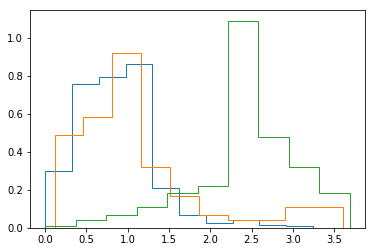

In [49]:
plt.hist(lmc['LOGG'], density = True, histtype= 'step')
plt.hist(smc["LOGG"], density = True, histtype= 'step')
plt.hist(mw_table['LOGG'], density = True, histtype= 'step')

(array([0.01205699, 0.01242797, 0.03338859, 0.08922173, 0.12780405,
        0.08068909, 0.2192517 , 0.90631464, 1.34982637, 0.91892811]),
 array([-2.4558165 , -2.1891434 , -1.9224702 , -1.6557971 , -1.389124  ,
        -1.1224508 , -0.85577774, -0.5891046 , -0.32243147, -0.05575835,
         0.21091478], dtype=float32),
 <a list of 1 Patch objects>)

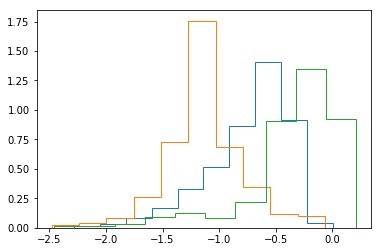

In [50]:
plt.hist(lmc['FE_H'], density = True, histtype= 'step')
plt.hist(smc["FE_H"], density = True, histtype= 'step')
plt.hist(mw_table['FE_H'], density = True, histtype= 'step')

(array([4.51903124e-05, 1.04502597e-04, 1.79990732e-04, 3.03750793e-04,
        3.80522971e-04, 7.46667207e-04, 1.39679147e-03, 1.52851096e-03,
        4.45997572e-04, 5.87987587e-05]),
 array([3572.9446, 3765.596 , 3958.2473, 4150.899 , 4343.5503, 4536.2017,
        4728.853 , 4921.5044, 5114.156 , 5306.807 , 5499.4585],
       dtype=float32),
 <a list of 1 Patch objects>)

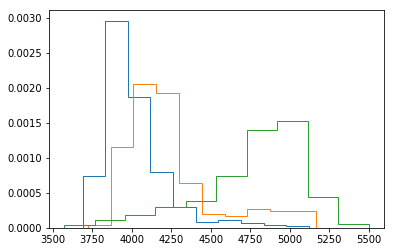

In [51]:
plt.hist(lmc['TEFF'], density = True, histtype= 'step')
plt.hist(smc["TEFF"], density = True, histtype= 'step')
plt.hist(mw_table['TEFF'], density = True, histtype= 'step')

(array([0.02772021, 0.86174864, 0.66044071, 0.43948642, 0.4812013 ,
        0.53502695, 0.38915944, 0.10603653, 0.60392378, 1.3359526 ]),
 array([0.56099999, 0.74479998, 0.92859998, 1.11239997, 1.29619997,
        1.47999996, 1.66379995, 1.84759995, 2.03139994, 2.21519994,
        2.39899993]),
 <a list of 1 Patch objects>)

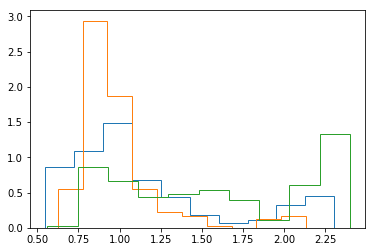

In [52]:
plt.hist(lmc['ISO_MEANM'], density = True, histtype= 'step')
plt.hist(smc["ISO_MEANM"], density = True, histtype= 'step')
plt.hist(mw_table['ISO_MEANM'], density = True, histtype= 'step')

(array([0.06480031, 0.30286103, 0.32139729, 0.71019916, 1.06514555,
        0.26425659, 0.16422207, 0.1182644 , 0.0729195 , 0.01286815]),
 array([0.49499999, 0.81789999, 1.14079999, 1.46369999, 1.78659999,
        2.10949999, 2.43239999, 2.75529999, 3.07819999, 3.40109999,
        3.72399999]),
 <a list of 1 Patch objects>)

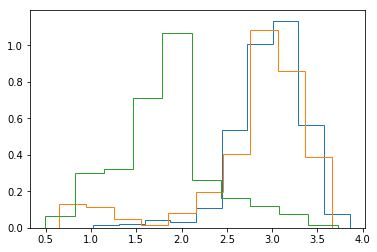

In [54]:
plt.hist(np.log10(lmc['ISO_MEANL']), density = True, histtype= 'step')
plt.hist(np.log10(smc["ISO_MEANL"]), density = True, histtype= 'step')
plt.hist(np.log10(mw_table['ISO_MEANL']), density = True, histtype= 'step')

(array([5.20467937e-02, 6.66935333e-03, 2.69357902e-03, 1.40169460e-03,
        9.97980716e-04, 7.16995854e-04, 4.00484171e-04, 2.35768907e-04,
        8.07427764e-05, 4.84456658e-05]),
 array([  2.39787855,  17.71372843,  33.02957831,  48.34542819,
         63.66127807,  78.97712795,  94.29297783, 109.60882771,
        124.92467759, 140.24052747, 155.55637735]),
 <a list of 1 Patch objects>)

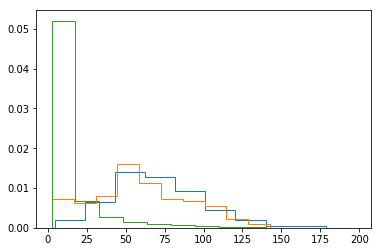

In [55]:
plt.hist((lmc['ISO_MEANR']), density = True, histtype= 'step')
plt.hist((smc["ISO_MEANR"]), density = True, histtype= 'step')
plt.hist((mw_table['ISO_MEANR']), density = True, histtype= 'step')

In [56]:
%run same_dat.py

In [58]:
# Make the Milkly Way look more like the LMC
mw_small, lmc_small = same_dat(mw_table, lmc)

In [59]:
mw_small

RADIALV,RADIAL_ERR,RADIAL_DATE,APOGEE_ID,VHELIO_AVG,TEFF,TEFF_ERR,LOGG,LOGG_ERR,FE_H,FE_H_ERR,ISO_MEANM,ISO_MEDIANM,ISO_STDM,ISO_MEANL,ISO_MEDIANL,ISO_STDL,ISO_MEANR
object,object,object,str18,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64
[-110.762856 -110.749275 -110.77072 -110.74828 -110.7291 ],[0.1 0.1 0.1 0.1 0.1],[57511. 57512. 57513. 57514. 57515.],2M16445462+4455308,-110.75,3850.6333,42.74539,0.907919,0.055939604,-0.41864523,0.0110647,1.1629999876022339,1.1629999876022339,0.0,772.6806030273438,772.6806030273438,0.0,62.458150370617155
[-88.02644 -87.718735 -88.02894 -87.1414 -86.88941 ],[0.10662618 0.1 0.1 0.1 0.1 ],[56788. 56795. 56802. 56590. 56597.],2M19412688+2505506,-87.4327,3836.7861,51.908817,0.44213077,0.0671132,-0.41433522,0.011938661,0.6449999809265137,0.6449999809265137,0.0,1039.9200439453125,1039.9200439453125,0.0,72.98241608620197
[64.22001 64.06025 63.83235 63.833576 63.992687 63.889206],[0.1 0.1 0.1 0.1 0.1 0.1],[56437. 56729. 56734. 56765. 56772. 56776.],2M16364758+0032131,63.9631,4001.8223,46.74892,1.2002825,0.055993084,-0.36477524,0.010496278,1.3919999599456787,1.3919999599456787,0.0,558.4701538085938,558.4701538085938,0.0,49.162939066202874
[32.1214 32.01673 31.784216 31.50962 31.419205 31.345863 31.828314],[0.1 0.1 0.1 0.1 0.1 0.1 0.1],[56653. 56671. 56701. 56729. 56735. 56756. 56764.],2M07300622+2352478,31.708,3878.8438,43.677948,0.6941363,0.058934543,-0.593972,0.011706636,2.1050000190734863,2.1050000190734863,0.0,2443.4306640625,2443.4306640625,0.0,109.45835027661454
[-9.394527 -9.304714 -9.477118 -9.000465 -9.004612 -9.241601],[0.1 0.1 0.1 0.1 0.1 0.1],[56437. 56729. 56734. 56765. 56772. 56776.],2M16332620-0037441,-9.21563,3990.9895,47.039364,0.85766816,0.06388808,-0.7800501,0.012463996,1.1823333501815796,1.1679999828338623,0.08187117427587509,1031.1915283203125,1018.5911254882812,90.793212890625,67.1679256576337
[-30.537792 -30.65348 -30.553656 -30.518217 -30.158352 -30.217716],[0.1 0.1 0.1 0.1 0.1 0.1],[55847. 55852. 55961. 55963. 56164. 56165.],2M03095584+4032280,-30.4618,4108.0327,50.00581,1.1734582,0.058808483,-0.45327306,0.010758387,2.1514999866485596,2.1514999866485596,0.0065000057220458984,1008.38623046875,1008.38623046875,24.375030517578125,62.69012220268221
[106.54762 106.30862 106.39508 106.846954 107.060524],[0.1 0.1 0.1 0.1 0.1],[57377. 57406. 57408. 57412. 57415.],2M06523358-0023120,106.718,3848.8342,42.742783,0.7243512,0.05654803,-0.46452522,0.01122557,2.006999969482422,2.006999969482422,0.0,1931.9683837890625,1931.9683837890625,0.0,98.85418263946043
[-53.98984 -53.97031 -54.007084 -53.992657 -54.02241 -54.040493 -54.02518 -54.020454],[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1],[56812. 56814. 56815. 56816. 56817. 56818. 56819. 56820.],2M19270488+4143598,-54.0098,3765.538,40.75854,0.60851705,0.057587583,-0.5615082,0.011835659,1.1786667108535767,1.1890000104904175,0.20303094387054443,1442.9625244140625,1462.177001953125,258.7712707519531,89.25383376127684
[17.166706 16.754332 16.052315 16.197218 16.250793],[0.1 0.1 0.1 0.1 0.1],[55816. 55822. 56051. 56063. 56065.],2M19400424+2429438,16.3991,3796.5105,41.347218,0.48006433,0.055191282,-0.42444524,0.011088378,0.6420000195503235,0.6420000195503235,0.0,1032.76123046875,1032.76123046875,0.0,74.28210801580897


In [ ]:
def histogram_maker(tables, plots):
    fig, ax = plt.subplots
    for var in plots:
        

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


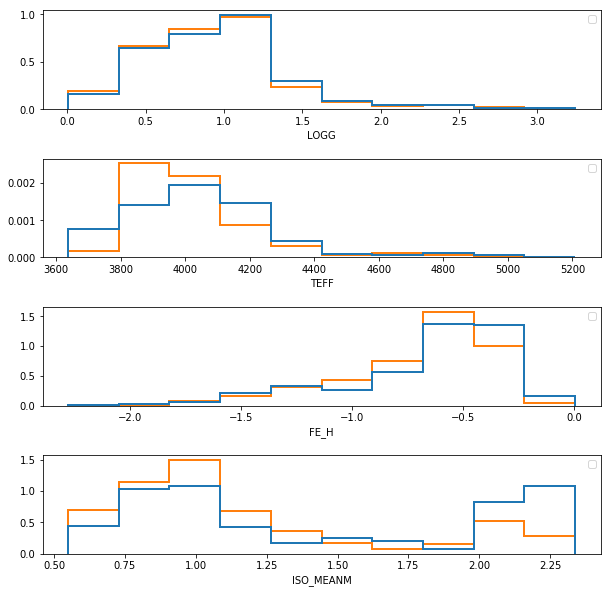

In [87]:
tables = [mw_small, lmc_small]
plots = ["LOGG", "TEFF", "FE_H", "ISO_MEANM"]
fig, ax = plt.subplots(len(plots), figsize = (10,10))
fig.subplots_adjust(hspace=.5)
for n in range(len(plots)):
    ax[n].hist([tables[0][plots[n]],tables[1][plots[n]]], histtype = 'step', density = True, linewidth=2)
#     ax[n].hist(tables[1][plots[n]], histtype = 'step', density = True, linewidth = 2)
    ax[n].set_xlabel(plots[n])
    ax[n].legend()

In [1]:
import pickle as rick
sampler_mw = rick.load( open( "mw-detection-same-lmc.pck", "rb" ) )
sampler_lmc = rick.load( open( "lmc-detection-same-mw.pck", "rb" ) )

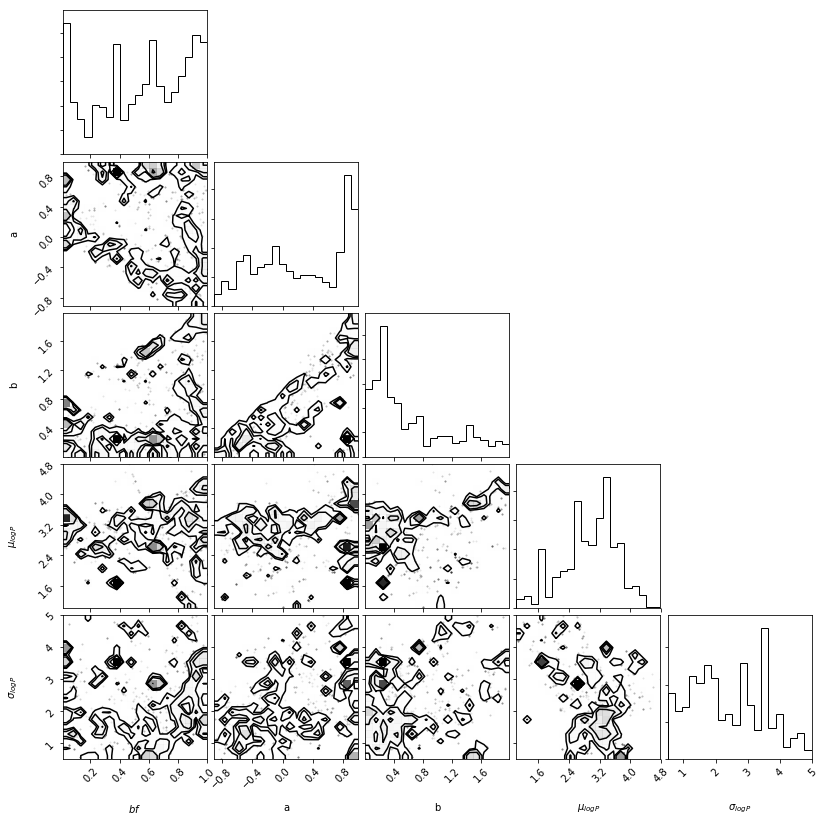

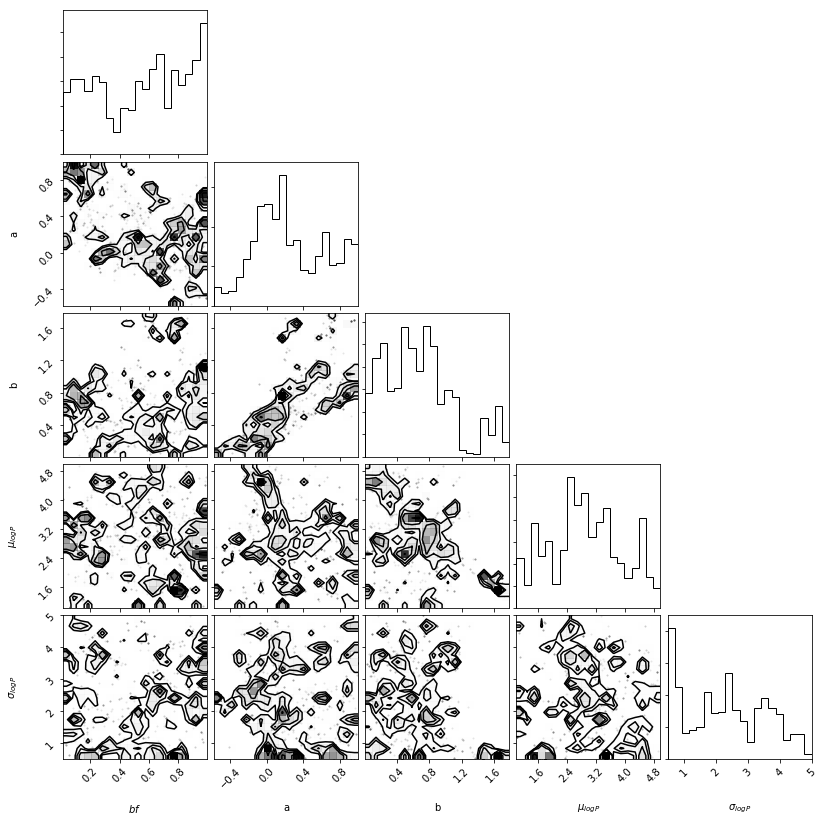

In [3]:
import corner
samples_mw = sampler_mw.chain[:,20:, :].reshape((-1, 5))
fig = corner.corner(samples_mw, labels=["$bf$",'a','b', "$\mu_{logP}$", "$\sigma_{logP}$"],
                    )
samples_lmc = sampler_lmc.chain[:,20:, :].reshape((-1, 5))
fig = corner.corner(samples_lmc, labels=["$bf$",'a','b', "$\mu_{logP}$", "$\sigma_{logP}$"],
                    )